In [1]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import math
import matplotlib.dates as mdates
import pickle

from numpy import sin,cos,pi,sqrt,exp,arcsin,arccos,arctan,dot,sum,abs
from scipy.special import erf, iv
from functools import reduce
from operator import add
from tqdm import tqdm
from pyproj import Transformer
from scipy.interpolate import splrep, splev
from astropy import units as u
from astropy.coordinates import CartesianRepresentation, GCRS, ITRS
from astropy.time import Time
from tletools import TLE
from matplotlib.ticker import FuncFormatter
plt.rc('xtick', labelsize=12)  
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=14)  
%matplotlib widget

In [2]:
R_const = 8.31
k_B = 1.38 * (10**-23)
m_O=16; m_O2=32; m_N=14; m_N2=28; m_H=1; m_He=4; m_Ar = 40; m_NO = 30;
m_p = 1.67 * (10**-27)
R_O = (R_const/m_O)*1000;
R_N = (R_const/m_N)*1000;
R_O2 = (R_const/m_O2)*1000;
R_N2 = (R_const/m_N2)*1000;
R_He = (R_const/m_He)*1000;
R_H = (R_const/m_H)*1000;
R_Ar = (R_const/m_Ar)*1000;
R_NO = (R_const/m_NO)*1000;
molar_masses = {
    'O': 16.00,
    'N2': 28.02,
    'O2': 32.00,
    'He': 4.00,
    'Ar': 39.95,
    'H': 1.01,
    'N': 14.01,
    'NO': 30.01,
    'AnomalousOxy': 16.00
}
KL_CLL = 2.89*10**6; KL_DRIA = 1.44*10**6
# angular velocity of the Earth vector

omega = np.array([0, 0, 7.2921150*10**-5]) # rad/s 

In [3]:
def gamma1(x):
    return (1/(2*sqrt(pi)))*(exp(-x**2) + sqrt(pi)*x*(1+erf(x)))
def gamma2(x):
    return (1/(2*sqrt(pi)))*(x*exp(-x**2) + (sqrt(pi)/2)*(1 + 2*(x**2))*(1+erf(x)))
def C1(x):
    return (2*x**2 + 3)*iv(0,0.5*x**2) + (2*x**2 + 1)*iv(1,0.5*x**2)
def C2(x):
    return (x**2 + 1)*iv(0,0.5*x**2) + (x**2)*iv(1,0.5*x**2)
def drag_CLL_plane(v,R,temp,angle,sigma_t,sigma_n,T_s):
    s = v/sqrt(2*R*temp)
    v_w = sqrt(pi*R*T_s/2)
    g = cos(angle)
    c1 = sigma_t*(1 - g**2)*gamma1(g*s)
    c2 = (2-sigma_n)*g*gamma2(g*s)/s
    c3 = sigma_n*(v_w/v)*gamma1(g*s)*g
    return (2/s)*(c1+c2+c3)
def drag_CLL_sphere(v,R,temp,sigma_t,sigma_n,T_s):
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    p0 = (2 - sigma_n + sigma_t)/(2*(s**3))
    p1= (((4*(s**4)) + (4*(s**2)) - 1)*erf(s)/(2*s)) + ((2*s**2 + 1)*exp(-s**2)/sqrt(pi))
    p2 = (4/3)*sigma_n*(v_w/v) 
    return (p0*p1) + p2
def drag_CLL_cyl(v,R,temp,angle,sigma_t,sigma_n,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    v_a = sqrt(2*R*temp);
    v_w = sqrt(pi*R*T_s/2);
    s = v/v_a
    g = sin(angle)
    mu = g*s
    p0 = (pi/2)*sigma_n*(v_w/v)*(g**2)
    p1 = (sqrt(pi)/(6*s))*(2*sigma_n - sigma_t - 4)*(g**2)*exp(-mu**2/2)*C1(mu)
    p2 = (sqrt(pi)*sigma_t/s)*(1 - g**2)*exp(-mu**2/2)*C2(mu)
    return p0 - p1 + p2
def drag_sat_CLL(v,temp,pitch,yaw,m_atm,nO,T_s,a,n_a,m_s): ## applicable for a flat-plate satellite model
    R_const = 8.31; R = (R_const/m_atm)*1000;
    pO = nO*k_B*temp; KL_CLL = 2.89*10**6;
    th = KL_CLL*pO/(1 + KL_CLL*pO);
    v_unit = (cos(-pitch)*cos(yaw),cos(-pitch)*sin(yaw),sin(-pitch))
    CD_CO = 0; CD_CL = 0;
    mu = m_atm/np.array(m_s) ## considers m_s is a list
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        alpha_n = (2*3.0*mu[i]/((1+mu[i])**2)) - 1
        if alpha_n < 0:
            alpha_n = 0
        sigma_n = 1 - sqrt(1-alpha_n)
        CD_CO = CD_CO + drag_CLL_plane(v,R,temp,angle,1,1,T_s)*a[i]
        CD_CL = CD_CL + drag_CLL_plane(v,R,temp,angle,1,sigma_n,T_s)*a[i]
    area = sat_area(pitch,yaw,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D
def drag_sat_CLL_const_alpha_sigma(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha_n, sigma_t): 
    ## applicable for a flat-plate satellite model
    R_const = 8.31
    R = (R_const / m_atm) * 1000
    v_unit = (cos(-pitch) * cos(yaw), cos(-pitch) * sin(yaw), sin(-pitch))
    CD = 0
    sigma_n = 1 - sqrt(1 - alpha_n)  # Use constant alpha_n to calculate sigma_n
    for i, n in enumerate(n_a):
        angle = arccos(dot(v_unit, n))
        CD = CD + drag_CLL_plane(v, R, temp, angle, sigma_t, sigma_n, T_s) * a[i]
    area = sat_area(pitch, yaw, a, n_a)
    C_D = CD / area
    return C_D
def drag_DRIA_plane(v,R,temp,angle,alpha,T_s):
    s = v/sqrt(2*R*temp)
    g=cos(angle)
    mu = g*s
    P = exp(-mu**2)/s
    Q = 1 + 1/(2*(s**2))
    Z = 1 + erf(g*s)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    return (P/sqrt(pi)) + (g*Q*Z) + ((g/2)*ratio*((g*sqrt(pi)*Z) + P))
def drag_DRIA_sphere(v,R,temp,alpha,T_s):
    s = v/sqrt(2*R*temp)
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = (2*s**2 + 1)*exp(-s**2)/(sqrt(pi) * s**3)
    p1 = (4*s**4 + 4*s**2 - 1)*erf(s)/(2 * s**4)
    p2 = (2*sqrt(pi)/3)*ratio
    return p0 + p1 + p2
def drag_DRIA_cyl(v,R,temp,angle,alpha,T_s):
    ## angle = angle between cylindrical axis and velocity vector
    s = v/sqrt(2*R*temp)
    g=sin(angle)
    mu = g*s
    ratio = sqrt((2/3)*(1 + alpha*((3*R*T_s/(v**2))-1)))
    p0 = s*sqrt(pi)*(g**2)*(1 + 1/(2 * s**2))*exp(-mu**2/2)*(iv(0,mu**2/2) + iv(1,mu**2/2))
    p1 = (sqrt(pi)/s)*exp(-mu**2/2)*iv(0,mu**2/2)
    p2 = (pi**1.5)*(g**2)*ratio/4
    return p0+p1+p2
def drag_sat_DRIA(v,temp,pitch,yaw,m_atm,nO,T_s,a,n_a,m_s):
    R_const = 8.31; R = (R_const/m_atm)*1000; 
    pO = nO*k_B*temp; KL_DRIA=1.44*10**6;
    th = KL_DRIA*pO/(1 + KL_DRIA*pO)
    v_unit = (cos(-pitch)*cos(yaw),cos(-pitch)*sin(yaw),sin(-pitch))
    mu = m_atm/np.array(m_s) ## considers m_s is a list
    CD_CO = 0; CD_CL = 0;
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        alpha = 3.0*mu[i]/((1+mu[i])**2)
        CD_CO = CD_CO + drag_DRIA_plane(v,R,temp,angle,1,T_s)*a[i]
        CD_CL = CD_CL + drag_DRIA_plane(v,R,temp,angle,alpha,T_s)*a[i]
    area = sat_area(pitch,yaw,a,n_a);
    C_D = (th*CD_CO + (1-th)*CD_CL)/area
    return C_D
def drag_sat_DRIA_const_alpha(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha):
    R_const = 8.31
    R = (R_const / m_atm) * 1000
    v_unit = (cos(-pitch) * cos(yaw), cos(-pitch) * sin(yaw), sin(-pitch))
    CD= 0;
    for i, n in enumerate(n_a):
        angle = arccos(dot(v_unit, n))
        CD = CD + drag_DRIA_plane(v, R, temp, angle, alpha, T_s) * a[i]
    area = sat_area(pitch, yaw, a, n_a)
    C_D = CD / area
    return C_D
def sat_area(pitch,yaw,a,n_a):
    area=0;
    v_unit = (cos(-pitch)*cos(yaw),cos(-pitch)*sin(yaw),sin(-pitch));
    for i,n in enumerate(n_a):
        angle = arccos(dot(v_unit,n))
        if angle < pi/2:
            area = area + a[i]*cos(angle)
    return area
def find_orbits(XYZ_TOD,start,stop):
    Z = XYZ_TOD['Z'][(XYZ_TOD.index >= start) & (XYZ_TOD.index <= stop)]
    idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
    orbit_end = Z.index[idxz]
    time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]
    return orbit_end, time_avg
def itrf_to_gcrf(itrf_coords, times):

    """
    Convert ITRF coordinates to GCRF coordinates.

    Parameters:
    itrf_coords (numpy.ndarray): Array of ITRF coordinates (x, y, z) in meters.
    times (numpy.ndarray): Array of times in ISO format.

    Returns:
    numpy.ndarray: Array of GCRF coordinates (x, y, z) in meters.
    """
    # Initialize an empty list to hold the GCRF coordinates
    gcrf_coords = []

    # Loop over each set of ITRF coordinates and corresponding time
    for coords, time in zip(itrf_coords, times):
        # Convert ITRF coordinates to astropy CartesianRepresentation
        itrf_representation = CartesianRepresentation(*coords, unit=u.m)

        # Create ITRS frame
        itrs_frame = ITRS(itrf_representation, obstime=Time(time))

        # Convert to GCRS frame
        gcrs_frame = itrs_frame.transform_to(GCRS(obstime=Time(time)))

        # Extract GCRF coordinates and append to the list
        gcrf_coords.append(gcrs_frame.cartesian.xyz.to(u.m).value)

    # Convert the list of GCRF coordinates to a numpy array and return
    return np.array(gcrf_coords)
def get_dates(filename,start_year,stop_year):
    # Initialize empty lists to store the start dates and stop dates
    start_dates = []
    stop_dates = []

    # Open the file
    with open(filename, 'r') as file:
        for i, line in enumerate(file):
            # If the line contains a start date, extract the date
            if line.startswith('start'):
                # Extract the date from the line
                date = dt.datetime.strptime(line[19:-2], '(%Y,%m,%d)')
                # Add the date to the start dates list
                if date.year >= start_year and date.year <= stop_year:
                    start_dates.append(date)
            # If the line contains a stop date, extract the date
            elif line.startswith('stop'):
                # Extract the date from the line
                date = dt.datetime.strptime(line[18:-2], '(%Y,%m,%d)')
                # Add the date to the stop dates list
                if date.year >= start_year and date.year <= stop_year:
                    stop_dates.append(date)
    if len(start_dates) > len(stop_dates):
        start_dates = start_dates[:len(stop_dates)]

    # Return the start dates and stop dates
    return start_dates, stop_dates
def quaternion_to_euler(w, x, y, z):
    """
    Convert a quaternion into pitch, roll, and yaw angles.
    
    Parameters:
    w, x, y, z : float
        Quaternion components.
    
    Returns:
    pitch, roll, yaw : float
        Euler angles in radians.
    """
    
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (w * x + y * z)
    cosr_cosp = 1 - 2 * (x * x + y * y)
    # atan2 ensures the angle is in the correct quadrant
    roll = math.atan2(sinr_cosp, cosr_cosp)
    
    # Pitch (y-axis rotation)
    sinp = 2 * (w * y - z * x)
    if abs(sinp) >= 1:
        # Handle out of range value for asin
        pitch = math.copysign(math.pi / 2, sinp)
    else:
        pitch = math.asin(sinp)
    
    # Yaw (z-axis rotation)
    siny_cosp = 2 * (w * z + x * y)
    cosy_cosp = 1 - 2 * (y * y + z * z)
    # atan2 ensures the angle is in the correct quadrant
    yaw = math.atan2(siny_cosp, cosy_cosp)
    
    return np.array([pitch, roll, yaw])
def enu_to_itrf(v_enu, lat, lon):
    """
    Converts wind velocity from East-North-Up (ENU) coordinates to ITRF (ECEF) coordinates.
    
    Parameters:
    - v_enu: A 3-element list or array containing velocity components in ENU coordinates [Ve, Vn, Vu]
    - lat: Latitude of the observation point in degrees
    - lon: Longitude of the observation point in degrees
    
    Returns:
    - A 3-element array containing velocity components in ITRF coordinates [Vx, Vy, Vz]
    """
    # Convert latitude and longitude to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Define the rotation matrix from ENU to ITRF coordinates
    R = np.array([
        [-np.sin(lon_rad), -np.sin(lat_rad) * np.cos(lon_rad), np.cos(lat_rad) * np.cos(lon_rad)],
        [ np.cos(lon_rad), -np.sin(lat_rad) * np.sin(lon_rad), np.cos(lat_rad) * np.sin(lon_rad)],
        [ 0,              np.cos(lat_rad),                    np.sin(lat_rad)]
    ])
    
    # Convert the ENU velocity vector to ITRF coordinates
    v_itrf = np.dot(R, v_enu)
    
    return v_itrf
def convert_enu_to_itrf(df_gitm, df_grace):
    """
    Convert ENU vectors to ITRF vectors and store the results in a DataFrame.

    Parameters:
    df_gitm (pd.DataFrame): DataFrame containing ENU vectors with columns 'V!Dn!N (east)', 'V!Dn!N (north)', 'V!Dn!N (up)'.
    df_grace (pd.DataFrame): DataFrame containing latitude and longitude with columns 'lat' and 'lon'.

    Returns:
    pd.DataFrame: DataFrame containing the ITRF vectors with columns 'Vx', 'Vy', 'Vz'.
    """
    num_rows = len(df_gitm)
    output_array = np.zeros((num_rows, 3))  # Initialize a 2D array to store the results

    for i in range(num_rows):
        enu_vector = np.array([df_gitm['V!Dn!N (east)'][i], df_gitm['V!Dn!N (north)'][i], df_gitm['V!Dn!N (up)'][i]])
        lat = df_grace['lat'][i]
        lon = df_grace['lon'][i]
        itrf_vector = enu_to_itrf(enu_vector, lat, lon)
        output_array[i] = itrf_vector

    df_wind = pd.DataFrame(output_array, index=df_gitm.index, columns=['Vx', 'Vy', 'Vz'])
    return df_wind
def itrf_to_enu(df, lat_col, lon_col, vel_x_col, vel_y_col, vel_z_col):
    """
    Convert wind velocity from ITRF (x, y, z) to ENU (east, north, up).
    
    Parameters:
    df (pd.DataFrame): DataFrame containing wind velocity in ITRF coordinates and geographic coordinates (latitude, longitude).
    lat_col (str): Column name for latitude in degrees.
    lon_col (str): Column name for longitude in degrees.
    vel_x_col (str): Column name for ITRF x-velocity.
    vel_y_col (str): Column name for ITRF y-velocity.
    vel_z_col (str): Column name for ITRF z-velocity.
    
    Returns:
    pd.DataFrame: DataFrame with the added ENU velocity components.
    """
    # Convert latitude and longitude from degrees to radians
    lat_rad = np.radians(df[lat_col])
    lon_rad = np.radians(df[lon_col])
    
    # Precompute sin and cos values for latitudes and longitudes
    sin_lat = np.sin(lat_rad)
    cos_lat = np.cos(lat_rad)
    sin_lon = np.sin(lon_rad)
    cos_lon = np.cos(lon_rad)
    
    # Extract ITRF velocity components
    v_x = df[vel_x_col]
    v_y = df[vel_y_col]
    v_z = df[vel_z_col]
    
    # Transformation matrix from ITRF to ENU
    east = -sin_lon * v_x + cos_lon * v_y
    north = -cos_lon * sin_lat * v_x - sin_lon * sin_lat * v_y + cos_lat * v_z
    up = cos_lat * cos_lon * v_x + cos_lat * sin_lon * v_y + sin_lat * v_z
    
    # Create new columns for ENU velocities
    df['vel_east'] = east
    df['vel_north'] = north
    df['vel_up'] = up
    
    return df
def tle_ratio(sat,start=None,stop=None):
    filepath = '/Users/user/OneDrive - The University of Texas at Dallas/Documents/MURI_Project_1/Data/TLE/'   
    filename = filepath + sat +'.txt'
    f = open(filename,'r')
    Data = f.readlines()
    f.close()
    epochs=[]; bstar=[]; dn_o2 = []; n =[]; a=[];
    if not sat == 'GRACEC':
        for i in range(int(len(Data)/2)):
            tle_str = sat+'\n' + Data[2*i] + Data[2*i + 1]
            tle_str = tle_str.strip().splitlines()
            tle = TLE.from_lines(*tle_str)
            epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))
            bstar.append(tle.bstar)
            dn_o2.append(tle.dn_o2)
            n.append(tle.n)
            a.append(tle.a)
    else:
        for i in range(int(len(Data)/3)):
            tle_str = sat+'\n' + Data[3*i + 1] + Data[3*i + 2]
            tle_str = tle_str.strip().splitlines()
            tle = TLE.from_lines(*tle_str)
            epochs.append(dt.datetime(tle.epoch_year,1,1,0,0,0) + dt.timedelta(days = tle.epoch_day - 1))
            bstar.append(tle.bstar)
            dn_o2.append(tle.dn_o2)
            n.append(tle.n)
            a.append(tle.a)

    epochs = pd.DatetimeIndex(epochs)
    if start == None:
        # idx0 = np.where(epochs <= dt.datetime(epochs[0].year+1,1,1))[0][-1]
        idx0 = 0
    else: ## if start date is specified
        idx0 = np.where(epochs <= start)[0][-1]

    if stop == None:
        # idx1 = np.where(epochs >= dt.datetime(epochs[-1].year,1,1))[0][0]
        idx1 = -1
    else: ## if stop date is specified 
        idx1 = np.where(epochs >= stop)[0][0]

    df = pd.DataFrame({'bstar':bstar,'dn_o2':dn_o2,'n':n,'a':a},index=pd.DatetimeIndex(epochs))
    df = df.iloc[idx0:idx1,:]
    return df
def scientific_formatter(x, pos):
    return f'{x / 1e14:.1f}x$10^{{14}}$'
def calculate_alpha(m_atm,K,nO,T_a):
    ms_avg = 120; # For GRACE
    K_s = 3.0; k_B = 1.38064852e-23; 
    mu = m_atm/ms_avg;
    alpha_ads = 1; alpha_s = K_s*mu/((1+mu)**2)
    P_O = nO*k_B*T_a; th = K*P_O/(1 + (K*P_O))
    alpha = alpha_ads*th + alpha_s*(1-th);
    return alpha

In [4]:
if os.name == 'nt':  # Windows
    filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\Temp\\'
else:  # Unix-based systems
    filepath = '/Volumes/seagate/Temp/'
os.chdir(filepath)
data_min = xr.open_dataset('OMNI_min.nc',engine='h5netcdf')

# Convert the xarray DataArray to a pandas DataFrame
df = data_min.to_dataframe()

# Drop duplicate rows
df = df.loc[~df.index.duplicated(keep='first')]

# Convert the pandas DataFrame back to an xarray DataArray
data_min = df.to_xarray()

del df

In [5]:
# For Gannon storm
os.chdir('/Volumes/seagate/Temp/')
filename = "20241119-00-16-supermag.txt"
lines = open(filename).readlines()
# find the row number that starts with "="
for i, line in enumerate(lines):
    if line.startswith("="):
        break

Data = np.loadtxt(filename,skiprows=i+2,delimiter='\t')
gs = pd.DataFrame(Data,columns = ['year','month','day','hour','min','sec','SME (nT)','No. of Stations SMEs','SMR (nT)'])
gs.index = pd.DatetimeIndex([dt.datetime(int(gs.iloc[i,0]),int(gs.iloc[i,1]),int(gs.iloc[i,2]),int(gs.iloc[i,3]),int(gs.iloc[i,4]),int(gs.iloc[i,5])) for i in range(len(gs))])

In [6]:
if os.name == 'nt':  # Windows
    filepath = 'C:\\Users\\soumy\\OneDrive - The University of Texas at Dallas\\Documents\\MURI_Project_1\\Data\\OMNI\\'
else:  # Unix-based systems
    filepath = '/Volumes/seagate/OMNI/'
os.chdir(filepath)

filename = 'omni2_solar_indices.txt';
SW_Data_hr = np.loadtxt(filename,dtype = float)
time_array = pd.DatetimeIndex([dt.datetime(int(SW_Data_hr[:,0][i]),1,1,0,0,0) +
               dt.timedelta(days = SW_Data_hr[:,1][i]-1) +
               dt.timedelta(hours = SW_Data_hr[:,2][i]) for i in range(len(SW_Data_hr))])

SW_Data_hr = pd.DataFrame(SW_Data_hr)
SW_Data_hr.columns = ['Year','DOY','Hour','KP index','R(sunspot no)','Dst index','Ap index','F10.7 index','AE','AU','AL','polar cap index','Lyman_alpha']
SW_Data_hr.index = time_array



In [7]:
a = [0.9551567,0.9551567,3.1554792,0.2282913,3.1554792,0.2282913,2.1673620,6.0711120,0.0461901]
n_a = [(1,0,0),(-1,0,0),(0,0.766044,-0.642787),(0,-0.766044,0.642787),(0,-0.766044,-0.642787),(0,0.766044,0.642787),(0,0,-1),(0,0,1),(1,0,0)]
m_s  = [382,382,60,382,60,382,60,100,382];

In [8]:
storm_dates = [
    (dt.datetime(2003, 10, 26), dt.datetime(2003, 11, 2)),  # storm 1
    (dt.datetime(2003, 11, 17), dt.datetime(2003, 11, 24)),  # storm 2
    (dt.datetime(2004, 11, 4), dt.datetime(2004, 11, 11)),  # storm 3
    (dt.datetime(2024, 5, 7), dt.datetime(2024, 5, 14))  # storm 4
];
ip_times = [dt.datetime(2003, 10, 29,6,10,0),
             dt.datetime(2003, 11, 20,8,2,0),
               dt.datetime(2004, 11, 7,18,27,0),
                 dt.datetime(2024, 5, 10,17,5,0)];

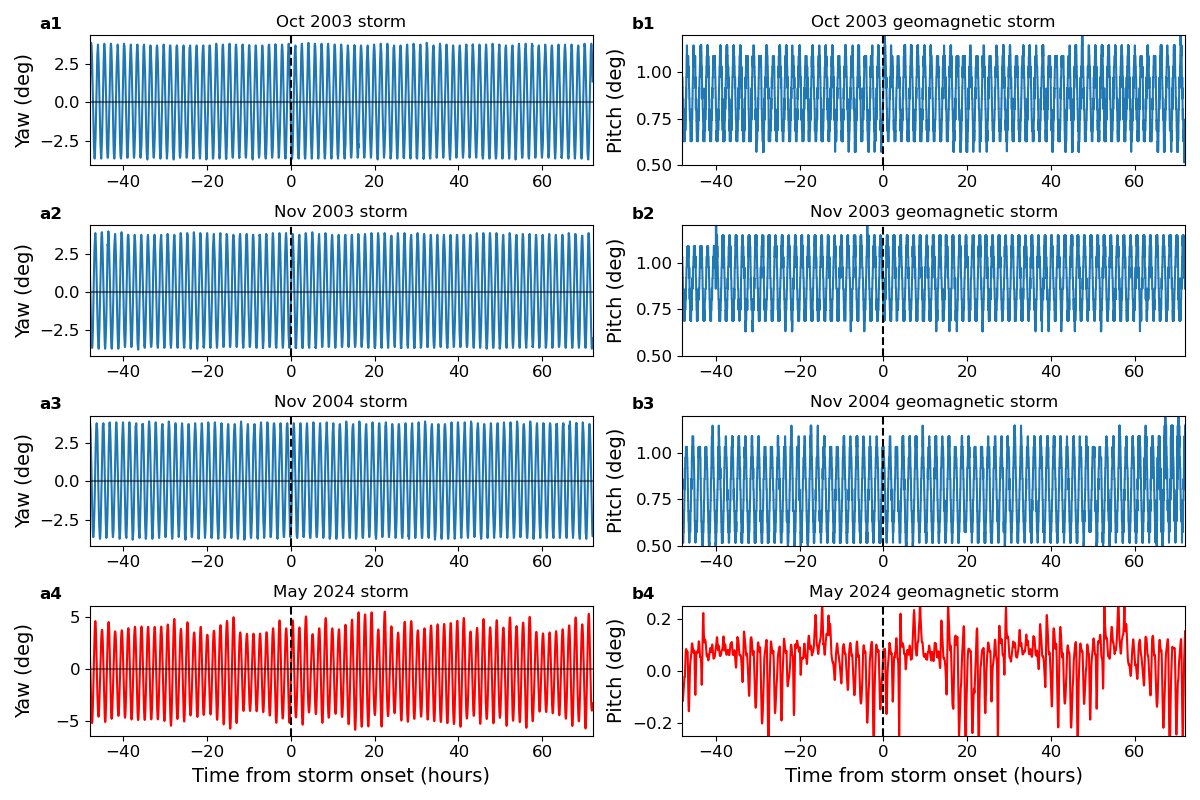

In [10]:
fig, ax = plt.subplots(4, 2, figsize=(12, 8))
n = 0
plot_labels = ['a1', 'b1', 'a2', 'b2', 'a3', 'b3', 'a4', 'b4']
for start, stop in storm_dates:
    ip = ip_times[n]
    os.chdir("/Volumes/seagate/Temp/")
    filename = f'GRACE_{start.strftime("%b")}_{start.strftime("%Y")}_GNV.nc'
    da_grace = xr.open_dataset(filename, engine='h5netcdf')
    df_grace = da_grace.to_dataframe()
    df_grace = df_grace[~df_grace.index.duplicated(keep='first')]

    # Plot Yaw angles in the left column
    if not start == dt.datetime(2024, 5, 7):
        ax[n, 0].plot((df_grace.index - ip) / dt.timedelta(hours=1), np.rad2deg(df_grace['Yaw (rad)']))
    else:
        ax[n, 0].plot((df_grace.index - ip) / dt.timedelta(hours=1), np.rad2deg(df_grace['Yaw (rad)']), color='r')
    ax[n, 0].set_ylabel('Yaw (deg)')
    ax[n, 0].axvline(0, color='k', linestyle='--')
    ax[n, 0].set_xlim(-48, 72)
    ax[n, 0].set_title(f'{start.strftime("%b")} {start.strftime("%Y")} storm')
    ax[n, 0].axhline(0, color='k', linestyle='-', alpha=0.5)
    ax[n, 0].text(-0.1, 1.05, plot_labels[2*n], transform=ax[n, 0].transAxes, fontsize=12, fontweight='bold')

    
    # Plot Pitch angles in the right column
    if not start == dt.datetime(2024, 5, 7):
        ax[n, 1].plot((df_grace.index - ip) / dt.timedelta(hours=1), np.rad2deg(df_grace['Pitch (rad)']))
    else:
        ax[n, 1].plot((df_grace.index - ip) / dt.timedelta(hours=1), np.rad2deg(df_grace['Pitch (rad)']), color='r')
    ax[n, 1].set_ylabel('Pitch (deg)')
    ax[n, 1].axvline(0, color='k', linestyle='--')
    ax[n, 1].set_xlim(-48, 72)
    ax[n, 1].set_title(f'{start.strftime("%b")} {start.strftime("%Y")} geomagnetic storm')
    if not n == 3:
        ax[n, 1].set_ylim(0.5, 1.2)
    else:
        ax[n, 1].set_ylim(-0.25, 0.25)
    # ax[n, 1].axhline(0, color='k', linestyle='-', alpha=0.5)
    ax[n, 1].text(-0.1, 1.05, plot_labels[2*n + 1], transform=ax[n, 1].transAxes, fontsize=12, fontweight='bold')
    n = n + 1

# Set common x-axis label for the bottom subplots
ax[3, 0].set_xlabel('Time from storm onset (hours)')
ax[3, 1].set_xlabel('Time from storm onset (hours)')

plt.tight_layout()
fig.align_ylabels()  # Align Y-axis labels vertically
os.chdir("/Volumes/seagate/Plots/")
plt.savefig('Yaw_Pitch_storms.png', dpi=1200)
plt.show()

In [11]:
# n=0
# for start,stop in storm_dates:
#     os.chdir("/Volumes/seagate/Temp/")
#     filename = f'GRACE_{start.strftime("%b")}_{start.strftime("%Y")}_GNV.nc'
#     da_grace = xr.open_dataset(filename,engine='h5netcdf')
#     df_grace = da_grace.to_dataframe()
#     df_grace = df_grace[~df_grace.index.duplicated(keep='first')]

#     plt.figure(figsize = (12,3))
#     if not start == dt.datetime(2024, 5, 7):
#         plt.scatter(df_grace.index, np.rad2deg(df_grace['Yaw (rad)']),s=1)
#     else:
#         plt.scatter(df_grace.index, np.rad2deg(np.abs(df_grace['Yaw (rad)'])-np.pi),color='r',s=1)
#     # plot ip times as vertical lines
#     ip = ip_times[n]
#     plt.axvline(ip,color='r',linestyle='--')
#     n+=1
#     # df_grace = df_grace.loc[ip-dt.timedelta(hours=48):ip+dt.timedelta(hours=72)]
# plt.tight_layout()

In [12]:
os.chdir("/Volumes/seagate/TIEGCM/extreme_events/my_runs/")
if start == dt.datetime(2003, 10, 26):
    os.chdir("/Volumes/seagate/TIEGCM/extreme_events/scavenged_run/")
filename = f"{start.strftime('%b')}_{start.strftime('%Y')}_GRACE.txt"
df_tiegcm = pd.read_csv(filename, comment='#', delim_whitespace=True,header=None)
header = [line for line in lines if line.startswith('#')]
columns = header[-2].split()[1:]

IndexError: list index out of range

In [97]:
storm_dates[2]

(datetime.datetime(2004, 11, 4, 0, 0), datetime.datetime(2004, 11, 11, 0, 0))

In [15]:
CD_models = {};
n=0;
for start, stop in storm_dates:
    ip = ip_times[n];
    os.chdir("/Volumes/seagate/Temp/")
    filename = f'GRACE_{start.strftime("%b")}_{start.strftime("%Y")}_GNV.nc'
    da_grace = xr.open_dataset(filename,engine='h5netcdf')
    df_grace = da_grace.to_dataframe()
    df_grace = df_grace[~df_grace.index.duplicated(keep='first')]
    df_grace = df_grace.loc[ip-dt.timedelta(hours=48):ip+dt.timedelta(hours=72)]
    
    Z = df_grace['zpos'].loc[start:stop]
    idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
    orbit_end = Z.index[idxz]
    
    earth_rot = np.cross(omega,df_grace[['xpos','ypos','zpos']])
    earth_rot = pd.DataFrame(earth_rot,columns=['xvel','yvel','zvel'],index=df_grace.index)

    df_grace['xvel'] = df_grace['xvel'] - earth_rot['xvel'];
    df_grace['yvel'] = df_grace['yvel'] - earth_rot['yvel'];
    df_grace['zvel'] = df_grace['zvel'] - earth_rot['zvel'];

    df_grace = itrf_to_enu(df_grace, 'lat', 'lon', 'xvel', 'yvel', 'zvel')
    V0 = df_grace[['vel_east','vel_north','vel_up']]
    pitch = df_grace['Pitch (rad)']; yaw = df_grace['Yaw (rad)'];
    if start == dt.datetime(2024,5,7):
        yaw = np.abs(df_grace['Yaw (rad)'])-np.pi;


    os.chdir("/Volumes/seagate/TIEGCM/extreme_events/my_runs/")
    if start == dt.datetime(2003, 10, 26):
        os.chdir("/Volumes/seagate/TIEGCM/extreme_events/scavenged_run/")
    filename = f"{start.strftime('%b')}_{start.strftime('%Y')}_GRACE.txt"
    df_tiegcm = pd.read_csv(filename, comment='#', delim_whitespace=True,header=None)

    #drop the last column
    df_tiegcm = df_tiegcm.drop(columns=[df_tiegcm.columns[-1]])
    lines = open(filename).readlines()
    header = [line for line in lines if line.startswith('#')]
    columns = header[-2].split()[1:]
    df_tiegcm.columns = columns[:-1]
    df_tiegcm["Datetime"] = pd.to_datetime(df_tiegcm[["Year", "Month", "Day", "Hour", "Min", "Sec"]].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H-%M-%S.%f')
    df_tiegcm.set_index("Datetime", inplace=True)
    df_tiegcm = df_tiegcm.loc[ip-dt.timedelta(hours=48):ip+dt.timedelta(hours=72)];
    #interpolate all columns of df_tiegcm to the GRACE time
    df1 = pd.DataFrame(index = df_grace.index, columns = df_tiegcm.columns)
    for col in df_tiegcm.columns:
        tck = splrep((df_tiegcm.index-start)/dt.timedelta(minutes=1), df_tiegcm[col],s=0, k=3)
        df1[col] = splev((df_grace.index-start)/dt.timedelta(minutes=1), tck,ext=3)
    df_tiegcm = df1;

    os.chdir("/Volumes/seagate/Temp/")
    df_gitm = pd.read_csv(f"grace_gitm_{start.strftime('%b')}_{start.strftime('%Y')}_aaron.csv")
    df_gitm.index = pd.DatetimeIndex(df_gitm['Unnamed: 0'])
    df_gitm = df_gitm.drop(columns=['Unnamed: 0'])
    df_gitm = df_gitm[~df_gitm.index.duplicated(keep='first')]
    df_gitm = df_gitm.loc[ip_times[n]-dt.timedelta(hours=48):ip_times[n]+dt.timedelta(hours=72)]
    #interpolate all columns of df_gitm to the GRACE time
    df1 = pd.DataFrame(index = df_grace.index, columns = df_gitm.columns)
    for col in df_gitm.columns:
        tck = splrep((df_gitm.index-start)/dt.timedelta(minutes=1), df_gitm[col],s=0, k=3)
        df1[col] = splev((df_grace.index-start)/dt.timedelta(minutes=1), tck,ext=3)
    df_gitm = df1;
    da_gitm = df_gitm.to_xarray()
    
    os.chdir("/Volumes/seagate/Temp/")
    df_msis = pd.read_csv(f'GRACEA_{start.strftime("%b")}_{start.strftime("%Y")}_MSIS.csv')
    df_msis.index = pd.DatetimeIndex(df_msis['index'])
    df_msis = df_msis.drop(columns=['index'])   
    df_msis = df_msis[~df_msis.index.duplicated(keep='first')]
    df_msis = df_msis.loc[ip-dt.timedelta(hours=48):ip+dt.timedelta(hours=72)]
    
    #interpolate all columns of df_msis to the GRACE time
    df1 = pd.DataFrame(index = df_grace.index, columns = df_msis.columns)
    for col in df_msis.columns:
        tck = splrep((df_msis.index-start)/dt.timedelta(minutes=1), df_msis[col],s=0, k=3)
        df1[col] = splev((df_grace.index-start)/dt.timedelta(minutes=1), tck,ext=3)
    df_msis = df1;
    da_msis = df_msis.to_xarray()

    # #interpolate each column of V0 to the TIEGCM time
    # # Interpolate each column of V0 to the TIEGCM time using splrep and splev
    # for col in V0.columns:
    #     tck = splrep((V0.index-start)/dt.timedelta(minutes=1), V0[col],s=0, k=3)
    #     df_tiegcm[col] = splev((df_tiegcm.index-start)/dt.timedelta(minutes=1), tck)
    V = np.sqrt((V0['vel_east']- df_tiegcm['Vn_Lon'])**2 + (V0['vel_north']- df_tiegcm['Vn_Lat'])**2 + (V0['vel_up']- df_tiegcm['WN'])**2)
    var_names = ['rho(O2)', 'rho(O)', 'N2', 'rho(NO)', 'rho(N4S)', 'HE']
    nO = df_tiegcm['DEN']*df_tiegcm['rho(O)']/(m_O*m_p); 
    nO2 = df_tiegcm['DEN']*df_tiegcm['rho(O2)']/(m_O2*m_p);
    nN2 = df_tiegcm['DEN']*df_tiegcm['N2']/(m_N2*m_p);
    nNO = df_tiegcm['DEN']*df_tiegcm['rho(NO)']/(m_NO*m_p);
    nN4S = df_tiegcm['DEN']*df_tiegcm['rho(N4S)']/(m_N*m_p);
    nHE = df_tiegcm['DEN']*df_tiegcm['HE']/(m_He*m_p);

    # find the total number density
    ntot = nO + nO2 + nN2 + nNO + nN4S + nHE;
    # calculate the mole fractions as a dataframe
    mole_frac_tgcm = pd.DataFrame({
        'O': nO/ntot,
        'O2': nO2/ntot,
        'N2': nN2/ntot,
        'NO': nNO/ntot,
        'N4S': nN4S/ntot,
        'He': nHE/ntot
    }, index=df_tiegcm.index)

    temp = df_tiegcm['T_n']
    T_s = 300;
    #calculate m_avg from the mass fractions
    m_avg = 1/(df_tiegcm['rho(O)']/m_O + df_tiegcm['rho(O2)']/m_O2 + df_tiegcm['N2']/m_N2 + df_tiegcm['HE']/m_He + df_tiegcm['rho(N4S)']/m_N + df_tiegcm['rho(NO)']/m_NO);
    #calculate mole fraction of O
    
    C_D = [];
    for i in range(len(V)):
        CD_O = drag_sat_CLL(V[i], temp[i], pitch[i], yaw[i], m_O, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(O)'][i]
        CD_N = drag_sat_CLL(V[i], temp[i], pitch[i], yaw[i], m_N, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(N4S)'][i]
        CD_O2 = drag_sat_CLL(V[i], temp[i], pitch[i], yaw[i], m_O2, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(O2)'][i]
        CD_N2 = drag_sat_CLL(V[i], temp[i], pitch[i], yaw[i], m_N2, nO[i], T_s, a, n_a, m_s) * df_tiegcm['N2'][i]
        CD_He = drag_sat_CLL(V[i], temp[i], pitch[i], yaw[i], m_He, nO[i], T_s, a, n_a, m_s) * df_tiegcm['HE'][i]
        CD_NO = drag_sat_CLL(V[i], temp[i], pitch[i], yaw[i], m_NO, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(NO)'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_NO))
    area =  np.array([sat_area(0,0,a,n_a) for i in range(len(V))]);
    CD_TGCM_CLL = pd.DataFrame({'CD':C_D,'A':area,'m_avg':m_avg},index=V.index);

    C_D = [];
    for i in range(len(V)):
        CD_O = drag_sat_DRIA(V[i], temp[i], pitch[i], yaw[i], m_O, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(O)'][i]
        CD_N = drag_sat_DRIA(V[i], temp[i], pitch[i], yaw[i], m_N, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(N4S)'][i]
        CD_O2 = drag_sat_DRIA(V[i], temp[i], pitch[i], yaw[i], m_O2, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(O2)'][i]
        CD_N2 = drag_sat_DRIA(V[i], temp[i], pitch[i], yaw[i], m_N2, nO[i], T_s, a, n_a, m_s) * df_tiegcm['N2'][i]
        CD_He = drag_sat_DRIA(V[i], temp[i], pitch[i], yaw[i], m_He, nO[i], T_s, a, n_a, m_s) * df_tiegcm['HE'][i]
        CD_NO = drag_sat_DRIA(V[i], temp[i], pitch[i], yaw[i], m_NO, nO[i], T_s, a, n_a, m_s) * df_tiegcm['rho(NO)'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_NO))
    area =  np.array([sat_area(0,0,a,n_a) for i in range(len(V))]);
    CD_TGCM_DRIA = pd.DataFrame({'CD':C_D,'A':area,'m_avg':m_avg},index=V.index);

    if n == 2:
        P_O = nO * 1.38064852e-23 * temp
        th_DRIA = 1.44e6 * P_O / (1 + (1.44e6 * P_O))
        th_CLL = 2.89e6 * P_O / (1 + (2.89e6 * P_O))
        alpha_DRIA = calculate_alpha(np.array(m_avg), 1.44e6, np.array(nO), np.array(temp))
        alpha_CLL = calculate_alpha(np.array(m_avg), 2.89e6, np.array(nO), np.array(temp))
        TGCM_alpha = pd.DataFrame({'alpha_DRIA': alpha_DRIA, 'alpha_CLL': alpha_CLL}, index=df_tiegcm.index)
        # take the average of first 48 hours for both DRIA and CLL, don't replace the variables
        TGCM_alpha_qt = TGCM_alpha.loc[start:start + dt.timedelta(hours=48)]
        alpha_DRIA_TGCM_qt = TGCM_alpha_qt['alpha_DRIA'].mean()
        alpha_CLL_TGCM_qt = TGCM_alpha_qt['alpha_CLL'].mean()
        alpha_n_DRIA = (2 * alpha_DRIA_TGCM_qt) - 1
        if alpha_n_DRIA < 0:
            alpha_n_DRIA = 0
        alpha_n_CLL = (2 * alpha_CLL_TGCM_qt) - 1
        if alpha_n_CLL < 0:
            alpha_n_CLL = 0
        # drag_sat_CLL_const_alpha_sigma(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha_n, sigma_t)
        C_D = []
        for i in range(len(V)):
            CD_O = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_O, T_s, a, n_a, alpha_n_CLL, 1) * df_tiegcm['rho(O)'][i]
            CD_N = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_N, T_s, a, n_a, alpha_n_CLL, 1) * df_tiegcm['rho(N4S)'][i]
            CD_O2 = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_O2, T_s, a, n_a, alpha_n_CLL, 1) * df_tiegcm['rho(O2)'][i]
            CD_N2 = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_N2, T_s, a, n_a, alpha_n_CLL, 1) * df_tiegcm['N2'][i]
            CD_He = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_He, T_s, a, n_a, alpha_n_CLL, 1) * df_tiegcm['HE'][i]
            CD_NO = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_NO, T_s, a, n_a, alpha_n_CLL, 1) * df_tiegcm['rho(NO)'][i]
            C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_NO))
        CD_TGCM_CLL_const_alpha = pd.DataFrame({'CD': C_D, 'A': area, 'm_avg': m_avg}, index=V.index)
        C_D = []
        for i in range(len(V)):
            # drag_sat_DRIA_const_alpha(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha)
            CD_O = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_O, T_s, a, n_a, alpha_DRIA_TGCM_qt) * df_tiegcm['rho(O)'][i]
            CD_N = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_N, T_s, a, n_a, alpha_DRIA_TGCM_qt) * df_tiegcm['rho(N4S)'][i]
            CD_O2 = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_O2, T_s, a, n_a, alpha_DRIA_TGCM_qt) * df_tiegcm['rho(O2)'][i]
            CD_N2 = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_N2, T_s, a, n_a, alpha_DRIA_TGCM_qt) * df_tiegcm['N2'][i]
            CD_He = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_He, T_s, a, n_a, alpha_DRIA_TGCM_qt) * df_tiegcm['HE'][i]
            CD_NO = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_NO, T_s, a, n_a, alpha_DRIA_TGCM_qt) * df_tiegcm['rho(NO)'][i]
            C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_NO))
        CD_TGCM_DRIA_const_alpha = pd.DataFrame({'CD': C_D, 'A': area, 'm_avg': m_avg}, index=V.index)


    # interpolate each column of V0 to the GITM time
    # for col in V0.columns:
    #     tck = splrep((V0.index-start)/dt.timedelta(minutes=1), V0[col],s=0, k=3)
    #     df_gitm[col] = splev((df_gitm.index-start)/dt.timedelta(minutes=1), tck)
    V = np.sqrt((V0['vel_east']- df_gitm['V!Dn!N (east)'])**2 + (V0['vel_north']-df_gitm['V!Dn!N (north)'])**2 + (V0['vel_up']- df_gitm['V!Dn!N (up)'])**2)

    # idx = np.where((df_grace.index >= df_gitm.index[0]) & (df_grace.index <= df_gitm.index[-1]))[0];
    # V = V[idx]; df_grace1 = df_grace.iloc[idx,:];
    nO = df_gitm['O(!U3!NP)'] + df_gitm['O(!U1!ND)']
    nO2 = df_gitm['O!D2!N']
    nN = df_gitm['N(!U2!ND)'] + df_gitm['N(!U2!NP)'] + df_gitm['N(!U4!NS)']
    nN2 = df_gitm['N!D2!N']
    nHe = df_gitm['He']
    nH = df_gitm['H']
    nNO = df_gitm['NO']
    ntot = nO + nO2 + nN + nN2 + nHe + nH + nNO
    mole_frac_gitm = pd.DataFrame({'O': nO / ntot, 'O2': nO2 / ntot, 'N': nN / ntot, 'N2': nN2 / ntot, 'He': nHe / ntot, 'H': nH / ntot, 'NO': nNO / ntot},
                            index=df_gitm.index)
    # Ensure that the molar masses dictionary keys match the var_names
    mass_frac_gitm = pd.DataFrame({
        var: mole_frac_gitm[var] * molar_masses[var] for var in mole_frac_gitm.columns
    }, index=mole_frac_gitm.index)
    m_avg = mass_frac_gitm.sum(axis=1)
    temp = df_gitm['Temperature']

    C_D = [];
    for i in range(len(V)):
        CD_O = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_O, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['O'][i]
        CD_N = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N'][i]
        CD_O2 = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['O2'][i]
        CD_N2 = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N2'][i]
        CD_He = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['He'][i]
        CD_H = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['H'][i]
        CD_NO = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_NO) / m_avg[i])
        
    area = np.array([sat_area(0,0,a,n_a) for i in range(len(V))]);
    CD_GITM_CLL = pd.DataFrame({'CD':C_D,'A':area,'m_avg':m_avg},index=V.index);
    C_D = [];
    for i in range(len(V)):
        CD_O = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_O, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['O'][i]
        CD_N = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N'][i]
        CD_O2 = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['O2'][i]
        CD_N2 = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N2'][i]
        CD_He = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['He'][i]
        CD_H = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['H'][i]
        CD_NO = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_NO) / m_avg[i])
        
    area = np.array([sat_area(0, 0, a, n_a) for i in range(len(V.index))])
    CD_GITM_DRIA = pd.DataFrame({'CD': C_D, 'A': area,'m_avg':m_avg}, index=V.index)

    if n == 2:
        P_O = nO*1.38064852e-23*temp;
        th_DRIA = 1.44e6*P_O/(1 + (1.44e6*P_O)); th_CLL = 2.89e6*P_O/(1 + (2.89e6*P_O));
        alpha_DRIA = calculate_alpha(np.array(m_avg),1.44e6,np.array(nO),np.array(temp));
        alpha_CLL = calculate_alpha(np.array(m_avg),2.89e6,np.array(nO),np.array(temp));
        GITM_alpha = pd.DataFrame({'alpha_DRIA':alpha_DRIA,'alpha_CLL':alpha_CLL},index=df_gitm.index);
        # take the average of first 48 hours for both DRIA and CLL, dont replace the variables
        GITM_alpha_qt = GITM_alpha.loc[start:start+dt.timedelta(hours=48)];
        alpha_DRIA_GITM_qt = GITM_alpha_qt['alpha_DRIA'].mean();
        alpha_CLL_GITM_qt = GITM_alpha_qt['alpha_CLL'].mean();
        alpha_n_DRIA = (2*alpha_DRIA_GITM_qt) - 1
        if alpha_n_DRIA < 0:
            alpha_n_DRIA = 0
        alpha_n_CLL = (2*alpha_CLL_GITM_qt) - 1
        if alpha_n_CLL < 0:
            alpha_n_CLL = 0
        # drag_sat_CLL_const_alpha_sigma(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha_n, sigma_t)
        C_D = [];
        for i in range(len(V)):
            CD_O = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_O, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['O'][i]
            CD_N = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_N, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['N'][i]
            CD_O2 = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_O2, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['O2'][i]
            CD_N2 = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_N2, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['N2'][i]
            CD_He = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_He, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['He'][i]
            CD_H = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_H, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['H'][i]
            CD_NO = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_NO, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_gitm['NO'][i]
            C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_NO) / m_avg[i])
        CD_GITM_CLL_const_alpha = pd.DataFrame({'CD':C_D,'A':area,'m_avg':m_avg},index=V.index);
        C_D = [];
        for i in range(len(V)):
            #drag_sat_DRIA_const_alpha(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha)
            CD_O = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_O, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['O'][i]
            CD_N = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_N, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['N'][i]
            CD_O2 = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_O2, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['O2'][i]
            CD_N2 = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_N2, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['N2'][i]
            CD_He = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_He, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['He'][i]
            CD_H = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_H, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['H'][i]
            CD_NO = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_NO, T_s, a, n_a, alpha_DRIA_GITM_qt) * mass_frac_gitm['NO'][i]
            C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_NO) / m_avg[i])
        CD_GITM_DRIA_const_alpha = pd.DataFrame({'CD':C_D,'A':area,'m_avg':m_avg},index=V.index);
            
            
    
        
    # # V = np.sqrt(V0['vel_east']**2 + V0['vel_north']**2 + V0['vel_up']**2)
    # # interpolate V to the MSIS time
    # tck = splrep(V.index.astype(int)/10**9,V.values,s=0,k=3)
    # V = splev(df_msis.index.astype(int)/10**9,tck,ext=3)

    var_names = list(da_msis.variables.keys())[2:-1]
    ntot = reduce(add, (da_msis[var] for var in var_names))
    nO = df_msis['O']
    mole_frac_msis = pd.DataFrame({var: da_msis[var].values/ntot.values for var in var_names},index=pd.DatetimeIndex(da_msis['index'].values))
    # convert the output array to a pandas DataFrame with the same index as df_gitm and columns 'Vx', 'Vy', 'Vz'
    temp = df_msis['Temperature'];
    T_s = 300;

    # Ensure that the molar masses dictionary keys match the var_names
    mass_frac_msis = pd.DataFrame({
        var: mole_frac_msis[var] * molar_masses[var] for var in mole_frac_msis.columns
    }, index=mole_frac_msis.index)
    m_avg = mass_frac_msis.sum(axis=1)

    C_D = [];
    for i in range(len(df_grace)):
        CD_O = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_O, nO[i], T_s, a, n_a, m_s) * (mass_frac_msis['O'][i] + mass_frac_msis['AnomalousOxy'][i])
        CD_N = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N'][i]
        CD_O2 = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['O2'][i]
        CD_N2 = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N2'][i]
        CD_He = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['He'][i]
        CD_H = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['H'][i]
        CD_Ar = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_Ar, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['Ar'][i]
        CD_NO = drag_sat_CLL(V[i], temp[i],pitch[i], yaw[i], m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
        
    area = np.array([sat_area(0,0,a,n_a) for i in range(len(df_grace))]);
    CD_MSIS_CLL = pd.DataFrame({'CD':C_D,'A':area,'m_avg':m_avg},index=df_grace.index);
    C_D = [];
    for i in range(len(df_grace)):
        CD_O = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_O, nO[i], T_s, a, n_a, m_s) * (mass_frac_msis['O'][i] + mass_frac_msis['AnomalousOxy'][i])
        CD_N = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N'][i]
        CD_O2 = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['O2'][i]
        CD_N2 = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N2'][i]
        CD_He = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['He'][i]
        CD_H = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['H'][i]
        CD_Ar = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_Ar, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['Ar'][i]
        CD_NO = drag_sat_DRIA(V[i], temp[i],pitch[i], yaw[i], m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
    area = np.array([sat_area(0, 0, a, n_a) for i in range(len(df_grace.index))])
    CD_MSIS_DRIA = pd.DataFrame({'CD': C_D, 'A': area,'m_avg':m_avg}, index=df_grace.index)
    if n == 2:
        P_O = nO * k_B * temp
        th_DRIA = 1.44e6 * P_O / (1 + (1.44e6 * P_O))
        th_CLL = 2.89e6 * P_O / (1 + (2.89e6 * P_O))
        alpha_DRIA = calculate_alpha(np.array(m_avg), 1.44e6, np.array(nO), np.array(temp))
        alpha_CLL = calculate_alpha(np.array(m_avg), 2.89e6, np.array(nO), np.array(temp))
        MSIS_alpha = pd.DataFrame({'alpha_DRIA': alpha_DRIA, 'alpha_CLL': alpha_CLL}, index=df_msis.index)
        # take the average of first 48 hours for both DRIA and CLL, don't replace the variables
        MSIS_alpha_qt = MSIS_alpha.loc[start:start + dt.timedelta(hours=48)]
        alpha_DRIA_MSIS_qt = MSIS_alpha_qt['alpha_DRIA'].mean()
        alpha_CLL_MSIS_qt = MSIS_alpha_qt['alpha_CLL'].mean()
        alpha_n_DRIA = (2 * alpha_DRIA_MSIS_qt) - 1
        if alpha_n_DRIA < 0:
            alpha_n_DRIA = 0
        alpha_n_CLL = (2 * alpha_CLL_MSIS_qt) - 1
        if alpha_n_CLL < 0:
            alpha_n_CLL = 0
        # drag_sat_CLL_const_alpha_sigma(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha_n, sigma_t)
        C_D = [];
        for i in range(len(V)):
            CD_O = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_O, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['O'][i]
            CD_N = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_N, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['N'][i]
            CD_O2 = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_O2, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['O2'][i]
            CD_N2 = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_N2, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['N2'][i]
            CD_He = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_He, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['He'][i]
            CD_H = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_H, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['H'][i]
            CD_Ar = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_Ar, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['Ar'][i]
            CD_NO = drag_sat_CLL_const_alpha_sigma(V[i], temp[i], pitch[i], yaw[i], m_NO, T_s, a, n_a, alpha_n_CLL, 1) * mass_frac_msis['NO'][i]
            C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
        CD_MSIS_CLL_const_alpha = pd.DataFrame({'CD': C_D, 'A': area, 'm_avg': m_avg}, index=V.index);
        C_D = [];
        for i in range(len(V)):
            # drag_sat_DRIA_const_alpha(v, temp, pitch, yaw, m_atm, T_s, a, n_a, alpha)
            CD_O = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_O, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['O'][i]
            CD_N = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_N, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['N'][i]
            CD_O2 = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_O2, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['O2'][i]
            CD_N2 = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_N2, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['N2'][i]
            CD_He = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_He, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['He'][i]
            CD_H = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_H, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['H'][i]
            CD_Ar = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_Ar, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['Ar'][i]
            CD_NO = drag_sat_DRIA_const_alpha(V[i], temp[i], pitch[i], yaw[i], m_NO, T_s, a, n_a, alpha_DRIA_MSIS_qt) * mass_frac_msis['NO'][i]
            C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
        CD_MSIS_DRIA_const_alpha = pd.DataFrame({'CD': C_D, 'A': area, 'm_avg': m_avg}, index=V.index);

    CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"] = {
        'MSIS_CLL': CD_MSIS_CLL,
        'MSIS_DRIA': CD_MSIS_DRIA,
        'GITM_CLL': CD_GITM_CLL,
        'GITM_DRIA': CD_GITM_DRIA,
        'TGCM_CLL': CD_TGCM_CLL,
        'TGCM_DRIA': CD_TGCM_DRIA,
        'GRACE': df_grace,
        'MSIS': df_msis,
        'GITM': df_gitm,
        'TGCM': df_tiegcm,
        'orbit_end': orbit_end,
        'start': start, 'stop': stop,
        'mole_frac_msis': mole_frac_msis,
        'mole_frac_gitm': mole_frac_gitm,
        'mole_frac_tgcm': mole_frac_tgcm,
    }
    if n == 2:
        CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"].update({
            'CD_GITM_CLL_const_alpha': CD_GITM_CLL_const_alpha,
            'CD_GITM_DRIA_const_alpha': CD_GITM_DRIA_const_alpha,
            'CD_MSIS_CLL_const_alpha': CD_MSIS_CLL_const_alpha,
            'CD_MSIS_DRIA_const_alpha': CD_MSIS_DRIA_const_alpha,
            'CD_TGCM_CLL_const_alpha': CD_TGCM_CLL_const_alpha,
            'CD_TGCM_DRIA_const_alpha': CD_TGCM_DRIA_const_alpha,
        })
    print(f"Finished {start.strftime('%b')} {start.strftime('%Y')}")
    print(len(df_gitm),len(df_msis),len(df_tiegcm),len(df_grace))
    n+=1


Finished Oct 2003
7196 7196 7196 7196
Finished Nov 2003
7196 7196 7196 7196
Finished Nov 2004
7196 7196 7196 7196
Finished May 2024
7201 7201 7201 7201


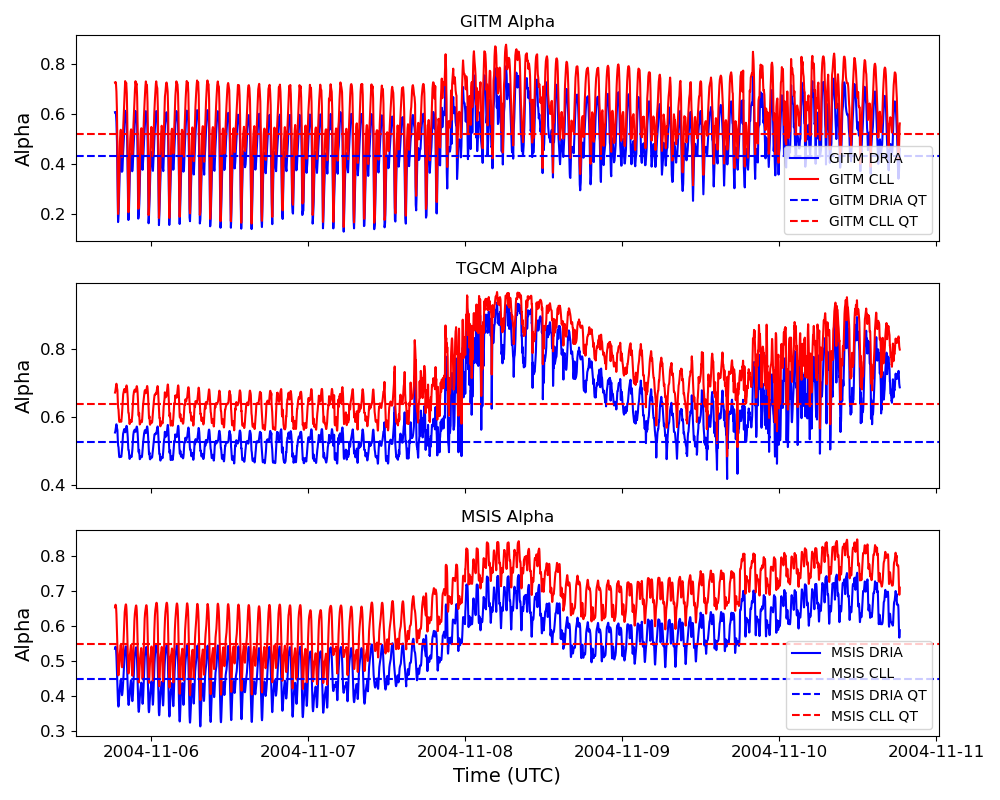

In [12]:
# plot all the alphas
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
ax[0].plot(GITM_alpha.index, GITM_alpha['alpha_DRIA'], label='GITM DRIA', color='blue')
ax[0].plot(GITM_alpha.index, GITM_alpha['alpha_CLL'], label='GITM CLL', color='red')
ax[0].axhline(alpha_DRIA_GITM_qt, color='blue', linestyle='--', label='GITM DRIA QT')
ax[0].axhline(alpha_CLL_GITM_qt, color='red', linestyle='--', label='GITM CLL QT')
ax[0].set_ylabel('Alpha')
ax[0].set_title('GITM Alpha')
ax[0].legend()

ax[1].plot(TGCM_alpha.index, TGCM_alpha['alpha_DRIA'], label='TGCM DRIA', color='blue')
ax[1].plot(TGCM_alpha.index, TGCM_alpha['alpha_CLL'], label='TGCM CLL', color='red')
ax[1].axhline(alpha_DRIA_TGCM_qt, color='blue', linestyle='--', label='TGCM DRIA QT')
ax[1].axhline(alpha_CLL_TGCM_qt, color='red', linestyle='--', label='TGCM CLL QT')
ax[1].set_ylabel('Alpha')
ax[1].set_title('TGCM Alpha')
ax[2].plot(MSIS_alpha.index, MSIS_alpha['alpha_DRIA'], label='MSIS DRIA', color='blue')
ax[2].plot(MSIS_alpha.index, MSIS_alpha['alpha_CLL'], label='MSIS CLL', color='red')
ax[2].axhline(alpha_DRIA_MSIS_qt, color='blue', linestyle='--', label='MSIS DRIA QT')
ax[2].axhline(alpha_CLL_MSIS_qt, color='red', linestyle='--', label='MSIS CLL QT')
ax[2].set_ylabel('Alpha')
ax[2].set_xlabel('Time (UTC)')
ax[2].set_title('MSIS Alpha')
ax[2].legend()
plt.tight_layout()


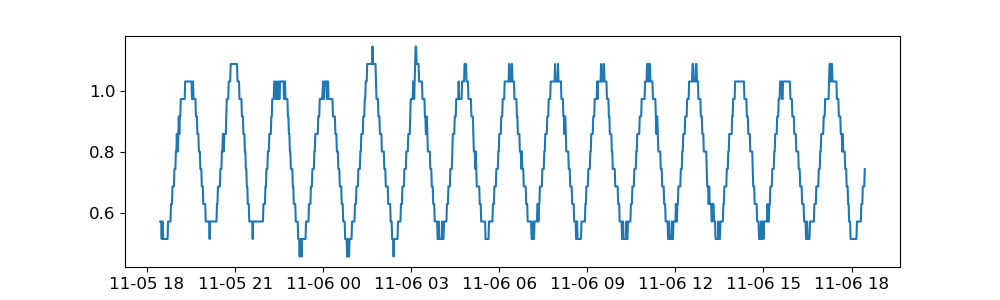

In [92]:
plt.figure(figsize=(10, 3))
plt.plot(np.rad2deg(CD_models['CD_models_Nov_2004']['GRACE']['Pitch (rad)'][:1440]))

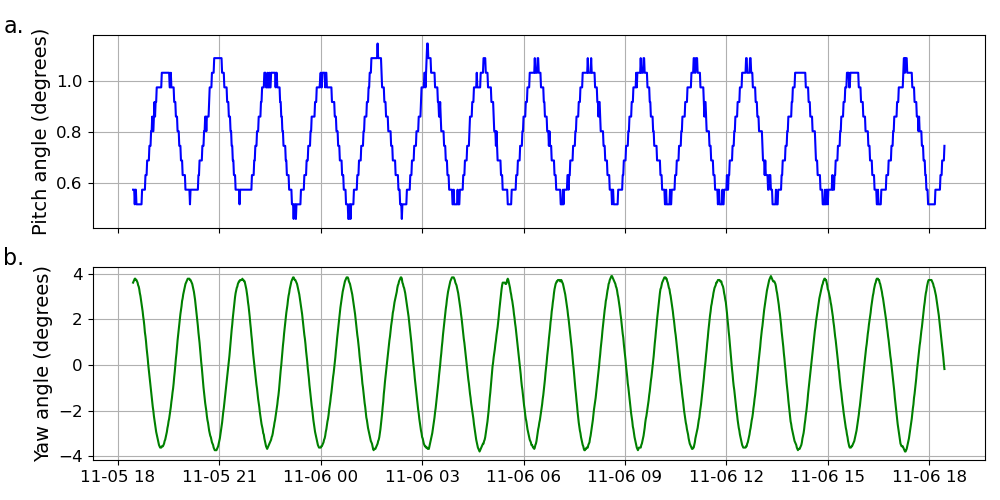

In [106]:

# Assuming CD_models is defined and contains the necessary data

# Extract the pitch and yaw data and convert to degrees
pitch_data = np.rad2deg(CD_models['CD_models_Nov_2004']['GRACE']['Pitch (rad)'][:1440])
yaw_data = np.rad2deg(CD_models['CD_models_Nov_2004']['GRACE']['Yaw (rad)'][:1440])

# Create the subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot the pitch data in the first subplot
axs[0].plot(pitch_data, label='Pitch (deg)', color='b', linestyle='-', linewidth=1.5)
axs[0].set_ylabel('Pitch angle (degrees)', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid(True)
# axs[0].legend(fontsize=14,loc='upper right')
axs[0].text(-0.1, 1.01, 'a.', transform=axs[0].transAxes, fontsize=16)

# Plot the yaw data in the second subplot
axs[1].plot(yaw_data, label='Yaw (deg)', color='g', linestyle='-', linewidth=1.5)
# axs[1].set_xlabel('Time Index', fontsize=14)
axs[1].set_ylabel('Yaw angle (degrees)', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid(True)
axs[1].text(-0.1, 1.01, 'b.', transform=axs[1].transAxes, fontsize=16)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/Volumes/seagate/Plots/Yaw_Pitch_Nov_2004.png', dpi=1200)
plt.show()

In [56]:
CD_models['CD_models_Oct_2003']['GITM_CLL']['CD'].iloc[:1070]

index
2003-10-27 06:10:00    3.802470
2003-10-27 06:11:00    3.759257
2003-10-27 06:12:00    3.715727
2003-10-27 06:13:00    3.665225
2003-10-27 06:14:00    3.601629
                         ...   
2003-10-27 23:55:00    3.163851
2003-10-27 23:56:00    3.180369
2003-10-27 23:57:00    3.200676
2003-10-27 23:58:00    3.221712
2003-10-28 00:00:00    3.278954
Name: CD, Length: 1070, dtype: float64

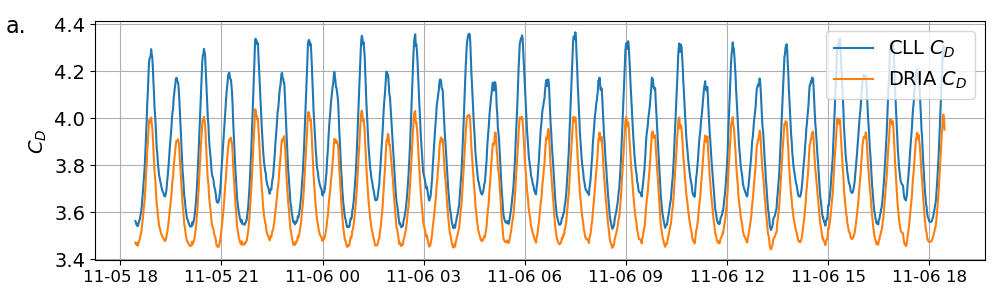

In [105]:

# Create the subplots
plt.figure(figsize=(10, 3))
GITM_CLL = CD_models['CD_models_Nov_2004']['MSIS_CLL']['CD'].iloc[:1440]
GITM_DRIA = CD_models['CD_models_Nov_2004']['MSIS_DRIA']['CD'].iloc[:1440]

# Plot the data
plt.plot(GITM_CLL, label='CLL $C_{D}$', linestyle='-', linewidth=1.5)
plt.plot(GITM_DRIA, label='DRIA $C_{D}$',ls='-', lw=1.5)

# Add labels and title
# plt.xlabel('Time Index', fontsize=14)
plt.ylabel('$C_D$', fontsize=14)
# plt.title('Drag Coefficient Comparison (GITM CLL vs DRIA)', fontsize=16)

# Customize ticks and grid
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='y',which='both',labelsize=14)
plt.grid(True)

# Add legend
plt.legend(fontsize=14, loc='upper right')
plt.text(-0.1, 0.95, 'a.', transform=plt.gca().transAxes, fontsize=16)
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/Volumes/seagate/Plots/CD_MSIS_Nov_2004.png', dpi=1200)
plt.show()

In [129]:
data = CD_models['CD_models_Nov_2004'];
CD_MSIS_CLL = data['MSIS_CLL']; CD_MSIS_CLL_const_alpha = data['CD_MSIS_CLL_const_alpha']
CD_MSIS_DRIA = data['MSIS_DRIA']; CD_MSIS_DRIA_const_alpha = data['CD_MSIS_DRIA_const_alpha']
CD_GITM_CLL = data['GITM_CLL']; CD_GITM_CLL_const_alpha = data['CD_GITM_CLL_const_alpha']
CD_GITM_DRIA = data['GITM_DRIA']; CD_GITM_DRIA_const_alpha = data['CD_GITM_DRIA_const_alpha']
CD_TGCM_CLL = data['TGCM_CLL']; CD_TGCM_CLL_const_alpha = data['CD_TGCM_CLL_const_alpha']
CD_TGCM_DRIA = data['TGCM_DRIA']; CD_TGCM_DRIA_const_alpha = data['CD_TGCM_DRIA_const_alpha']
orbit_end = data['orbit_end']

# calculate orbit avg values of the drag coefficients
CD_MSIS_CLL_avg = [CD_MSIS_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_MSIS_DRIA_avg = [CD_MSIS_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
# constant alpha
CD_MSIS_CLL_const_alpha_avg = [CD_MSIS_CLL_const_alpha['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_MSIS_DRIA_const_alpha_avg = [CD_MSIS_DRIA_const_alpha['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

CD_GITM_CLL_avg = [CD_GITM_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_GITM_DRIA_avg = [CD_GITM_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
# constant alpha
CD_GITM_CLL_const_alpha_avg = [CD_GITM_CLL_const_alpha['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_GITM_DRIA_const_alpha_avg = [CD_GITM_DRIA_const_alpha['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

CD_TGCM_CLL_avg = [CD_TGCM_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_TGCM_DRIA_avg = [CD_TGCM_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
# constant alpha
CD_TGCM_CLL_const_alpha_avg = [CD_TGCM_CLL_const_alpha['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_TGCM_DRIA_const_alpha_avg = [CD_TGCM_DRIA_const_alpha['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]

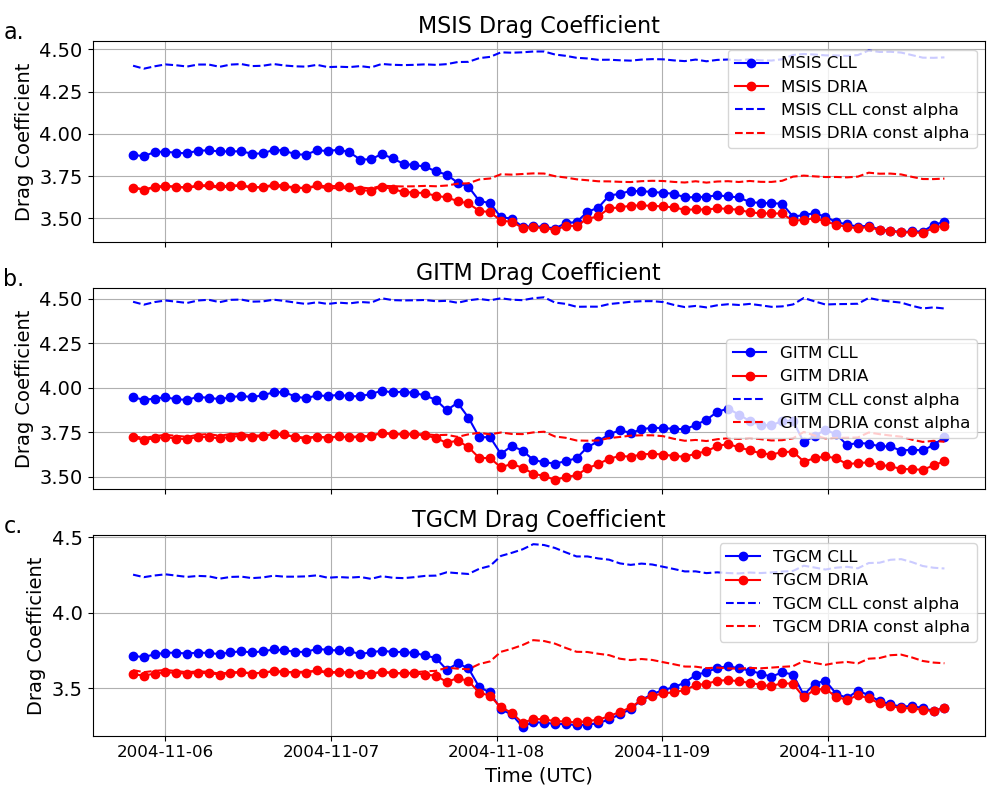

In [132]:
#create a (3,1) subplot
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
# plot the average drag coefficients
ax[0].plot(time_avg, CD_MSIS_CLL_avg, label='MSIS CLL', color='blue', marker='o')
ax[0].plot(time_avg, CD_MSIS_DRIA_avg, label='MSIS DRIA', color='red', marker='o')
ax[0].plot(time_avg, CD_MSIS_CLL_const_alpha_avg, label='MSIS CLL const alpha', color='blue', linestyle='--')
ax[0].plot(time_avg, CD_MSIS_DRIA_const_alpha_avg, label='MSIS DRIA const alpha', color='red', linestyle='--')
ax[0].set_ylabel('Drag Coefficient', fontsize=14)
ax[0].set_title('MSIS Drag Coefficient', fontsize=16)
ax[0].legend(fontsize=12)
# plot the average drag coefficients
ax[1].plot(time_avg, CD_GITM_CLL_avg, label='GITM CLL', color='blue', marker='o')
ax[1].plot(time_avg, CD_GITM_DRIA_avg, label='GITM DRIA', color='red', marker='o')
ax[1].plot(time_avg, CD_GITM_CLL_const_alpha_avg, label='GITM CLL const alpha', color='blue', linestyle='--')
ax[1].plot(time_avg, CD_GITM_DRIA_const_alpha_avg, label='GITM DRIA const alpha', color='red', linestyle='--')
ax[1].set_ylabel('Drag Coefficient', fontsize=14)
ax[1].set_title('GITM Drag Coefficient', fontsize=16)
ax[1].legend(fontsize=12)
# plot the average drag coefficients
ax[2].plot(time_avg, CD_TGCM_CLL_avg, label='TGCM CLL', color='blue', marker='o')
ax[2].plot(time_avg, CD_TGCM_DRIA_avg, label='TGCM DRIA', color='red', marker='o')
ax[2].plot(time_avg, CD_TGCM_CLL_const_alpha_avg, label='TGCM CLL const alpha', color='blue', linestyle='--')
ax[2].plot(time_avg, CD_TGCM_DRIA_const_alpha_avg, label='TGCM DRIA const alpha', color='red', linestyle='--')
ax[2].set_ylabel('Drag Coefficient', fontsize=14)
ax[2].set_xlabel('Time (UTC)', fontsize=14)
ax[2].set_title('TGCM Drag Coefficient', fontsize=16)
# Add legend
ax[2].legend(fontsize=12)
# Customize ticks and grid
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='y', which='both', labelsize=14)
ax[1].tick_params(axis='y', which='both', labelsize=14)
ax[2].tick_params(axis='y', which='both', labelsize=14)
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].text(-0.1, 1.01, 'a.', transform=ax[0].transAxes, fontsize=16)
ax[1].text(-0.1, 1.01, 'b.', transform=ax[1].transAxes, fontsize=16)
ax[2].text(-0.1, 1.01, 'c.', transform=ax[2].transAxes, fontsize=16)
# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('/Volumes/seagate/Plots/CD_avg.png', dpi=300)
plt.show()

In [62]:
storm_dates[3]

(datetime.datetime(2024, 5, 7, 0, 0), datetime.datetime(2024, 5, 14, 0, 0))

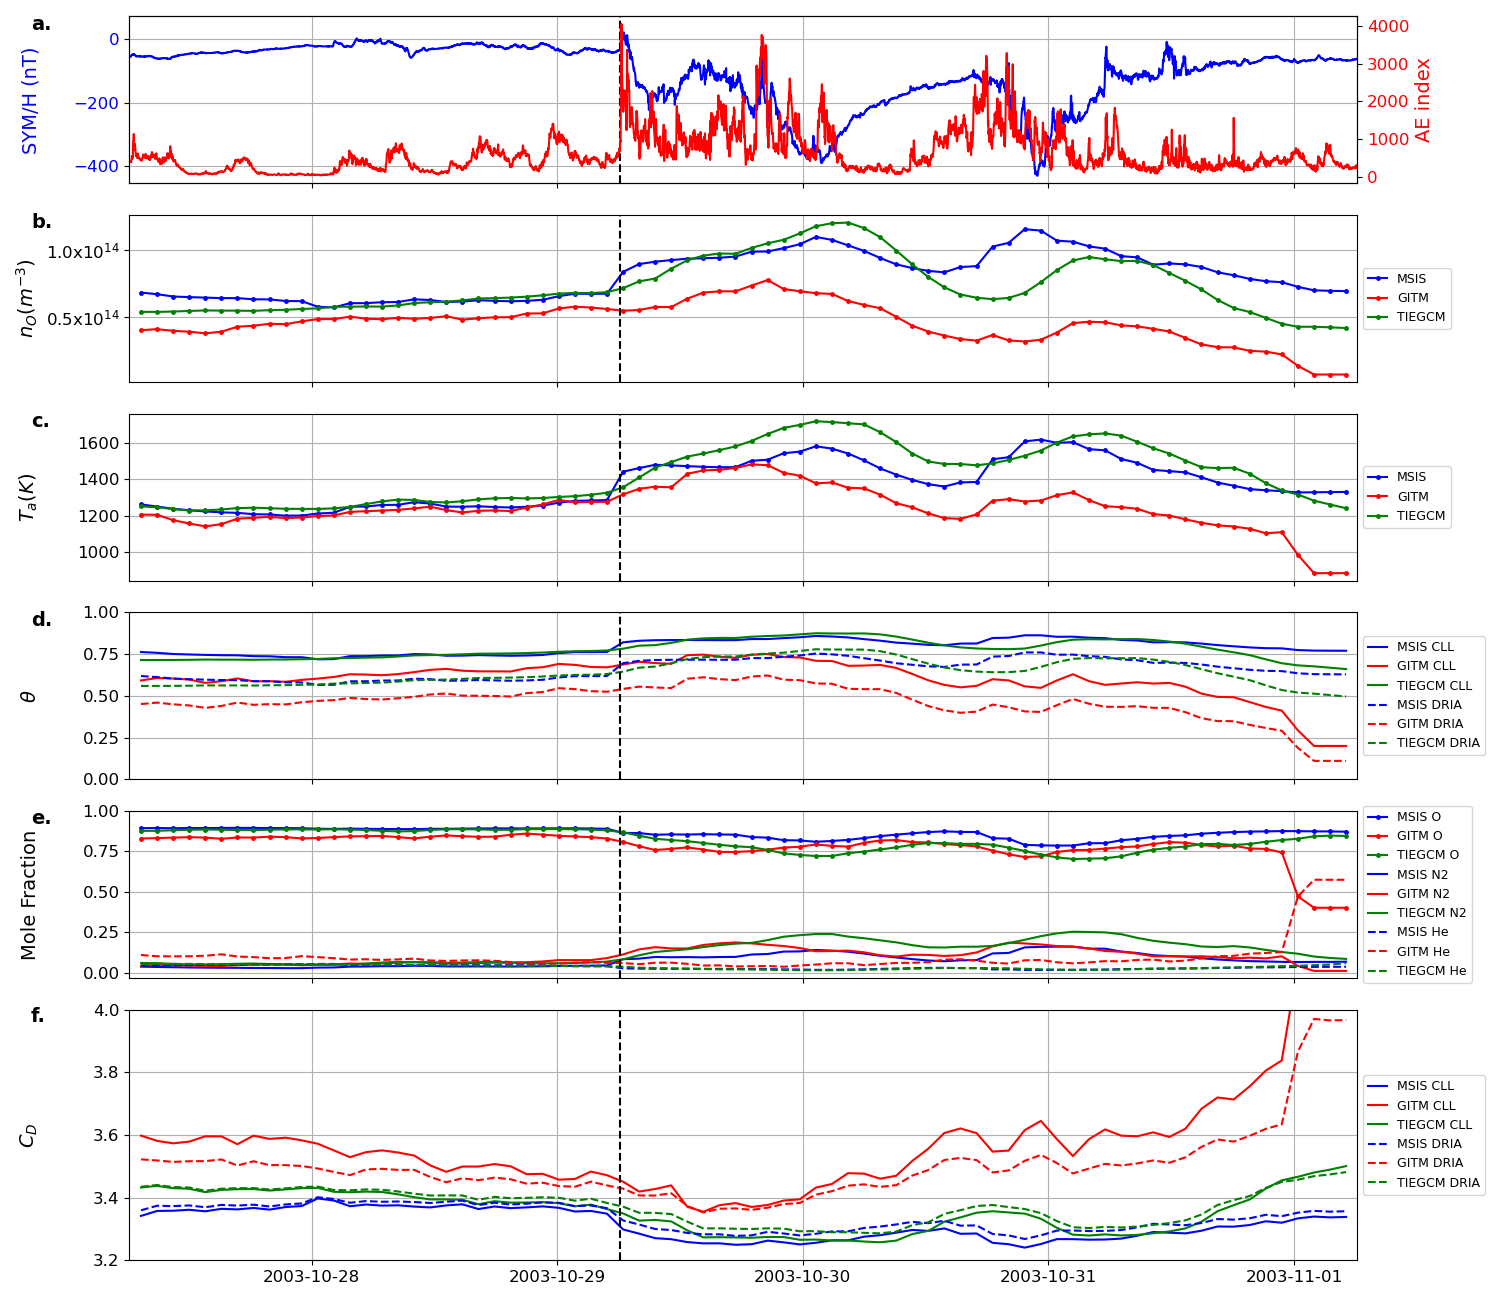

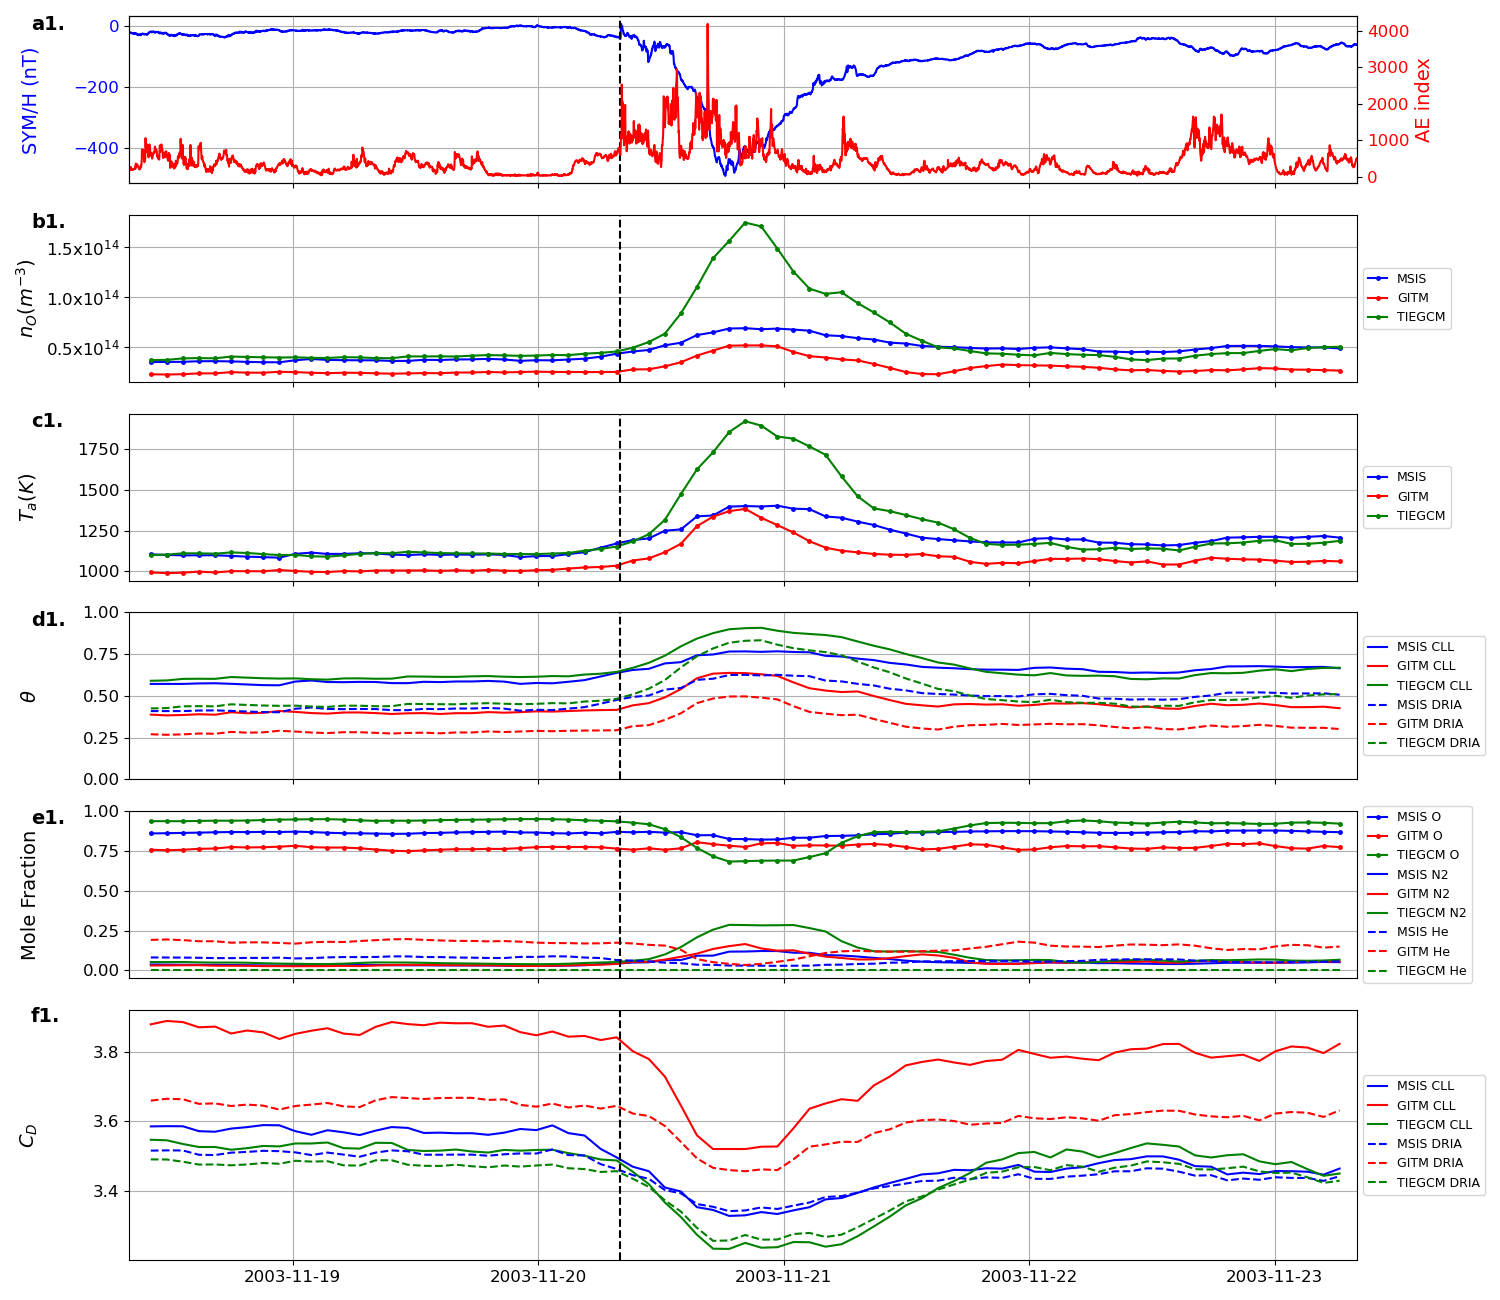

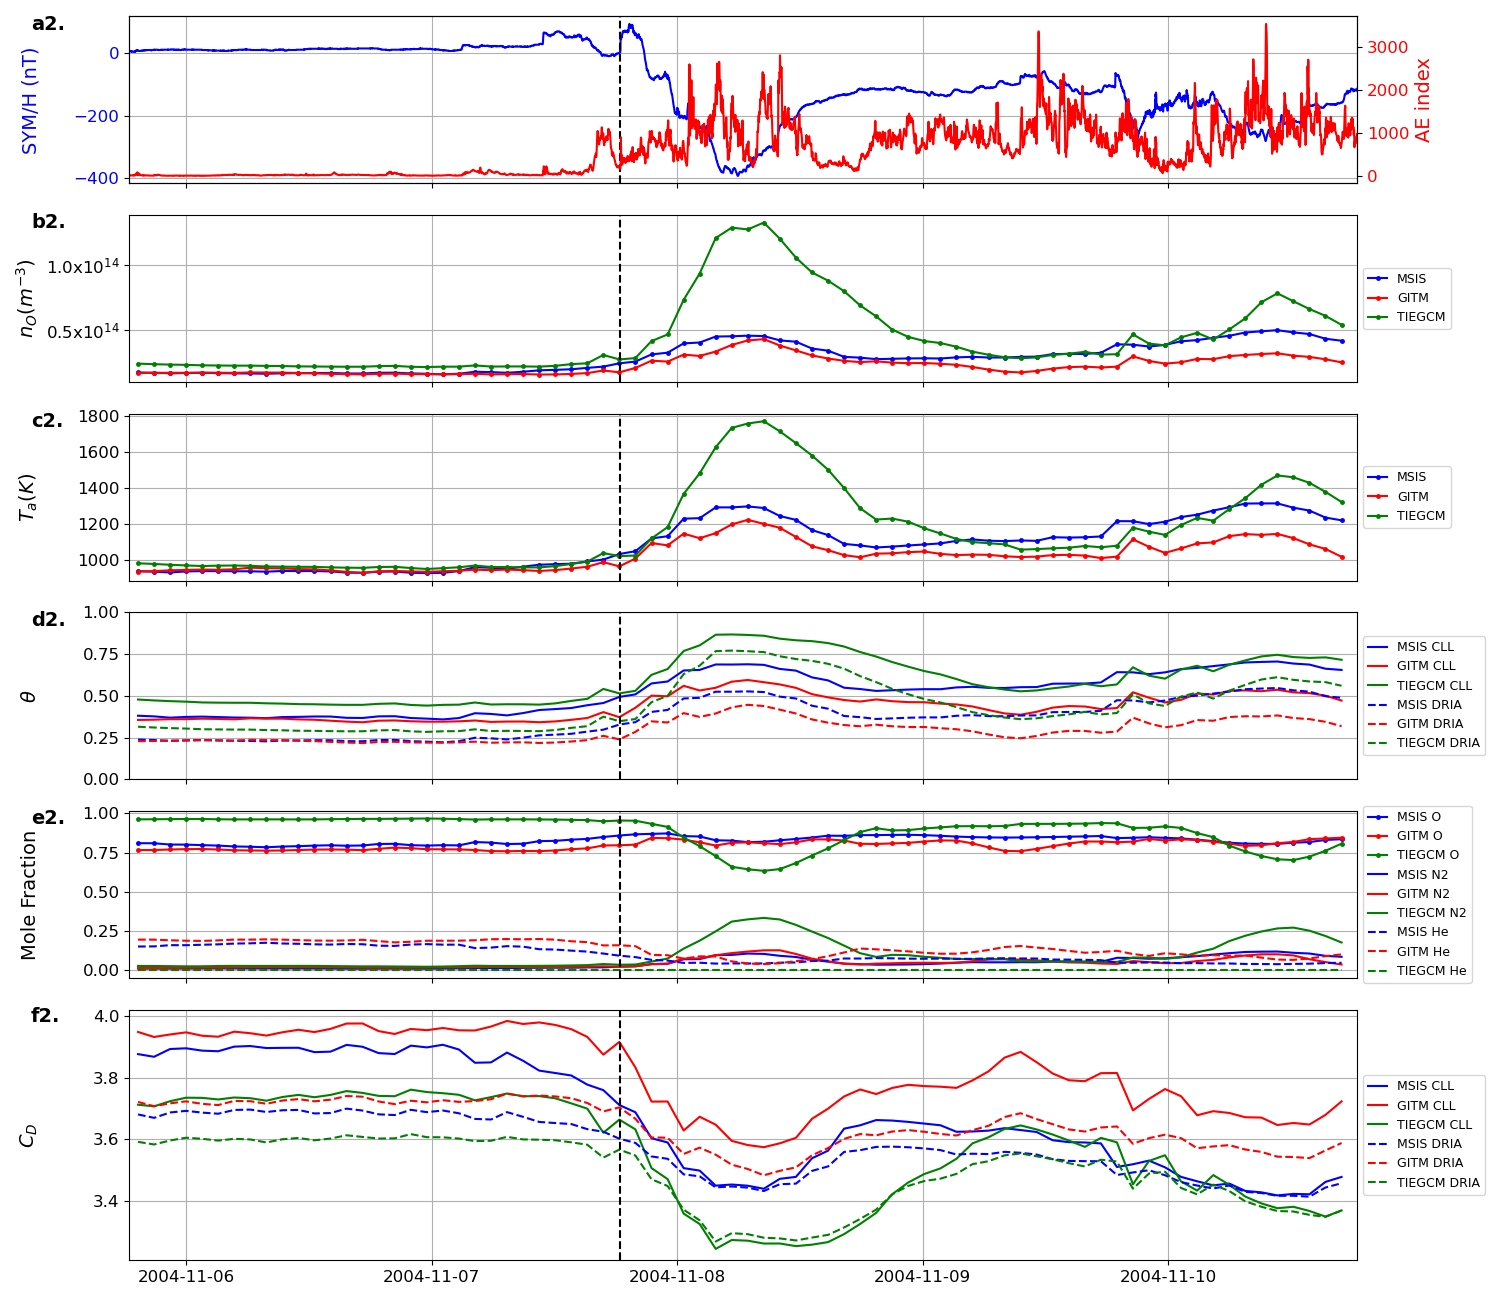

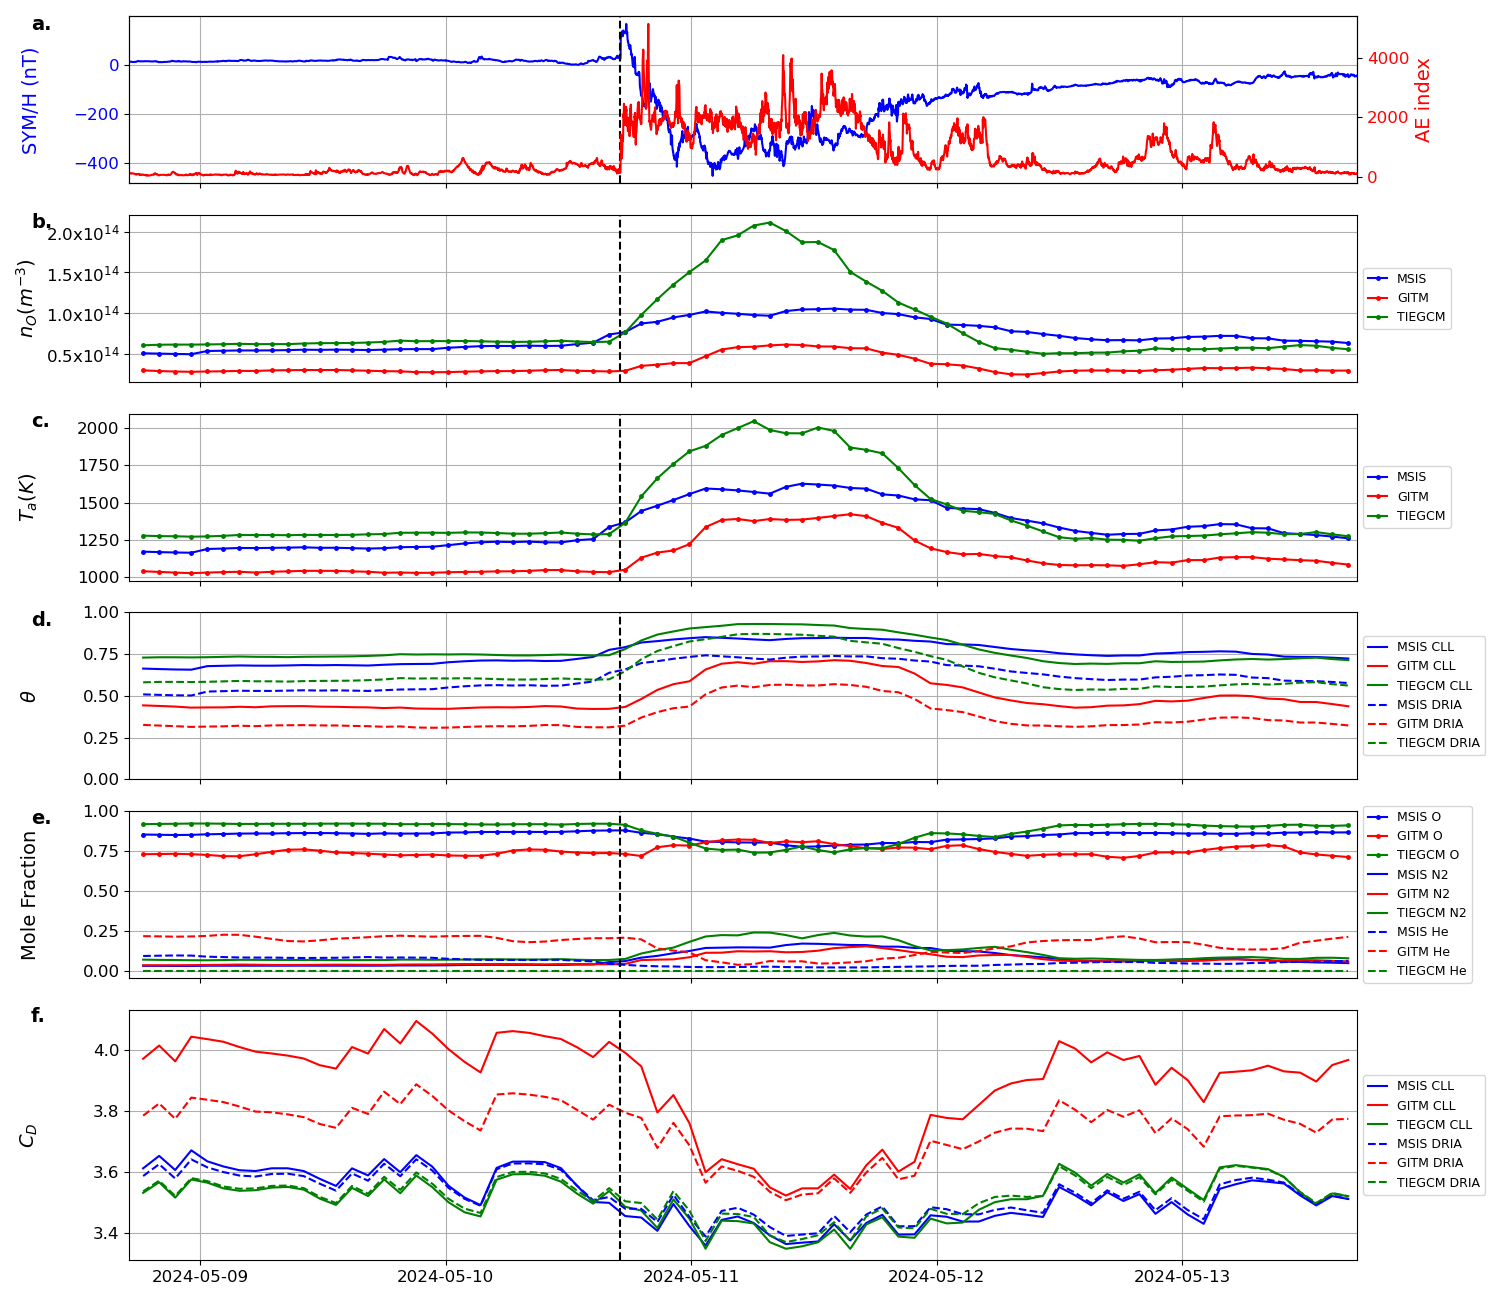

In [76]:
n= 0;
# plt.figure(figsize=(12,4))
for start,stop in storm_dates:
    x0 = ip_times[n] - dt.timedelta(hours=48); x1 = ip_times[n] + dt.timedelta(hours=72);

    CD_MSIS_CLL = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['MSIS_CLL']
    CD_MSIS_DRIA = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['MSIS_DRIA']
    CD_GITM_CLL = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['GITM_CLL']
    CD_GITM_DRIA = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['GITM_DRIA']
    CD_TGCM_CLL = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['TGCM_CLL']
    CD_TGCM_DRIA = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['TGCM_DRIA']
    df_grace = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['GRACE']
    df_msis = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['MSIS']
    df_gitm = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['GITM']
    df_tiegcm = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['TGCM']
    orbit_end = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['orbit_end']
    mole_frac_gitm = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['mole_frac_gitm']
    mole_frac_msis = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['mole_frac_msis']
    mole_frac_tgcm = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['mole_frac_tgcm']

    time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]
    rho_avg_msis = [df_msis['rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    rho_avg_gitm = [df_gitm['Rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    rho_avg_tgcm = [df_tiegcm['DEN'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    mole_frac_gitm_O_avg = [mole_frac_gitm['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    mole_frac_msis_O_avg = [mole_frac_msis['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    mole_frac_tgcm_O_avg = [mole_frac_tgcm['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    #same for N2
    mole_frac_gitm_N2_avg = [mole_frac_gitm['N2'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    mole_frac_msis_N2_avg = [mole_frac_msis['N2'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    mole_frac_tgcm_N2_avg = [mole_frac_tgcm['N2'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    #same for He
    mole_frac_gitm_He_avg = [mole_frac_gitm['He'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    mole_frac_msis_He_avg = [mole_frac_msis['He'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    mole_frac_tgcm_He_avg = [mole_frac_tgcm['He'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    # plt.plot((pd.DatetimeIndex(time_avg)-ip_times[n])/dt.timedelta(hours=1), mole_frac_gitm_He_avg, '-o', ms=2.5, label= f'{start.strftime("%b")} {start.strftime("%Y")}')

    #averaged yaw angle
    yaw_avg = np.rad2deg([np.abs(df_grace['Yaw (rad)'].loc[orbit_end[i]:orbit_end[i+1]]).mean() for i in range(len(orbit_end)-1)])
    pitch_avg = np.rad2deg([np.abs(df_grace['Pitch (rad)'].loc[orbit_end[i]:orbit_end[i+1]]).mean() for i in range(len(orbit_end)-1)])
    
 
    PO_msis = df_msis['O']*k_B*df_msis['Temperature']
    theta_msis_CLL = (PO_msis*KL_CLL)/(1+(PO_msis*KL_CLL));
    theta_msis_CLL_avg = [theta_msis_CLL.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    theta_msis_DRIA = (PO_msis*KL_DRIA)/(1+(PO_msis*KL_DRIA));
    theta_msis_DRIA_avg = [theta_msis_DRIA.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    PO_gitm = df_gitm['O(!U3!NP)']*k_B*df_gitm['Temperature']
    theta_gitm_CLL = (PO_gitm*KL_CLL)/(1+(PO_gitm*KL_CLL));
    theta_gitm_CLL_avg = [theta_gitm_CLL.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    theta_gitm_DRIA = (PO_gitm*KL_DRIA)/(1+(PO_gitm*KL_DRIA));
    theta_gitm_DRIA_avg = [theta_gitm_DRIA.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    PO_tgcm = (df_tiegcm['rho(O)']*df_tiegcm['DEN']/(m_O*m_p))*k_B*df_tiegcm['T_n']
    theta_tgcm_CLL = (PO_tgcm*KL_CLL)/(1+(PO_tgcm*KL_CLL));
    theta_tgcm_CLL_avg = [theta_tgcm_CLL.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    theta_tgcm_DRIA = (PO_tgcm*KL_DRIA)/(1+(PO_tgcm*KL_DRIA));
    theta_tgcm_DRIA_avg = [theta_tgcm_DRIA.loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    
    O_msis = [df_msis['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    O_gitm = [df_gitm['O(!U3!NP)'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    O_tgcm = [(df_tiegcm['rho(O)']*df_tiegcm['DEN']/(m_O*m_p)).loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

    fig, ax = plt.subplots(6, 1, figsize=(15, 13), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 1,1.5]})
    # plt.subplots_adjust(hspace=0.1)
    SW_min = data_min.sel(index=slice(start, stop))
    # X = (pd.DatetimeIndex(SW_min.index.values) - ip_times[n])/dt.timedelta(days=1)
    ax1 = ax[0].twinx()

    # if SW_min not empty
    if len(SW_min.index) > 0:
        
        # Plot SYM/H index on the left y-axis
        ax[0].plot(SW_min.index,SW_min['SYM_H'], label='SYM/H index', color='b')
        # Plot AE index on the right y-axis
        ax1.plot(SW_min.index,SW_min['AE'], label='AE index', color='r')
        
    else: #for Gannon storm
        # X = (gs.index - ip_times[n])/dt.timedelta(days=1)
        ax[0].plot(gs.index,gs['SMR (nT)'], label='SYM/H index', color='b')
        ax1.plot(gs.index,gs['SME (nT)'], label='AE index', color='r')

    ax[0].set_ylabel('SYM/H (nT)', color='b')
    ax[0].tick_params(axis='y', labelcolor='b')
    ax1.set_ylabel('AE index', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # ax[1].plot(time_avg, rho_avg_msis, '-o', ms=2.5, label='MSIS', color='b')
    # ax[1].plot(time_avg, rho_avg_gitm, '-o', ms=2.5, label='GITM', color='r')
    # ax[1].plot(time_avg, rho_avg_tgcm, '-o', ms=2.5, label='TIEGCM', color='g')
    # ax[1].set_ylabel('Neutral Dens')
    # ax[1].grid()
    # ax[1].legend()
    # X = (pd.DatetimeIndex(time_avg) - ip_times[n])/dt.timedelta(days=1) 

    ax[1].plot(time_avg, O_msis, '-o', ms=2.5, label='MSIS', color='b')
    ax[1].plot(time_avg, O_gitm, '-o', ms=2.5, label='GITM', color='r')
    ax[1].plot(time_avg, O_tgcm, '-o', ms=2.5, label='TIEGCM', color='g')
    ax[1].set_ylabel('$n_O (m^{-3})$')

    # Set the y-axis formatter for ax[1]
    ax[1].yaxis.set_major_formatter(FuncFormatter(scientific_formatter))
    # ax[1].legend(loc='center left',bbox_to_anchor=(1, 0.5))

    # Plot the temperature from MSIS and GITM
    # Calculate avg temperature using orbit_end
    temp_msis = [df_msis['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    temp_gitm = [df_gitm['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    temp_tgcm = [df_tiegcm['T_n'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    ax[2].plot(time_avg, temp_msis, '-o', ms=2.5, label='MSIS', color='b')
    ax[2].plot(time_avg, temp_gitm, '-o', ms=2.5, label='GITM', color='r')
    ax[2].plot(time_avg, temp_tgcm, '-o', ms=2.5, label='TIEGCM', color='g')
    ax[2].set_ylabel('$T_a (K)$')
    # ax[2].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    
    # plot average theta from each model
    ax[3].plot(time_avg, theta_msis_CLL_avg, '-', ms=2.5, label='MSIS CLL', color='b')
    ax[3].plot(time_avg, theta_gitm_CLL_avg, '-', ms=2.5, label='GITM CLL', color='r')
    ax[3].plot(time_avg, theta_tgcm_CLL_avg, '-', ms=2.5, label='TIEGCM CLL', color='g')

    ax[3].plot(time_avg, theta_msis_DRIA_avg, '--', ms=2.5, label='MSIS DRIA', color='b')
    ax[3].plot(time_avg, theta_gitm_DRIA_avg, '--', ms=2.5, label='GITM DRIA', color='r')
    ax[3].plot(time_avg, theta_tgcm_DRIA_avg, '--', ms=2.5, label='TIEGCM DRIA', color='g')

    ax[3].set_yticks(np.arange(0, 1.1, 0.25))
    ax[3].set_ylabel(r'$\theta$')
    # ax[3].legend(loc='center left',bbox_to_anchor=(1, 0.5))

    #plot the O mole fraction from each model
    ax[4].plot(time_avg, mole_frac_msis_O_avg, '-o', ms=2.5, label='MSIS O', color='b')
    ax[4].plot(time_avg, mole_frac_gitm_O_avg, '-o', ms=2.5, label='GITM O', color='r')
    ax[4].plot(time_avg, mole_frac_tgcm_O_avg, '-o', ms=2.5, label='TIEGCM O', color='g')
    ax[4].plot(time_avg, mole_frac_msis_N2_avg, '-', ms=2.5, label='MSIS N2', color='b')
    ax[4].plot(time_avg, mole_frac_gitm_N2_avg, '-', ms=2.5, label='GITM N2', color='r')
    ax[4].plot(time_avg, mole_frac_tgcm_N2_avg, '-', ms=2.5, label='TIEGCM N2', color='g')
    ax[4].plot(time_avg, mole_frac_msis_He_avg, '--', ms=2.5, label='MSIS He', color='b')
    ax[4].plot(time_avg, mole_frac_gitm_He_avg, '--', ms=2.5, label='GITM He', color='r')
    ax[4].plot(time_avg, mole_frac_tgcm_He_avg, '--', ms=2.5, label='TIEGCM He', color='g')
    ax[4].set_ylabel('Mole Fraction')
    ax[4].set_yticks(np.arange(0, 1.1, 0.25))
    # ax[4].legend(loc='center left',bbox_to_anchor=(1, 0.5))

    CD_MSIS_CLL_avg = [CD_MSIS_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    CD_MSIS_DRIA_avg = [CD_MSIS_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    CD_GITM_CLL_avg = [CD_GITM_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    CD_GITM_DRIA_avg = [CD_GITM_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    CD_TGCM_CLL_avg = [CD_TGCM_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
    CD_TGCM_DRIA_avg = [CD_TGCM_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)] 

    # print("storm start: ",start,"storm end: ",stop)
    # print("CD_MSIS_DRIA_avg = " + str(np.mean(CD_MSIS_DRIA_avg[:14])))
    # print("CD_MSIS_CLL_avg = " + str(np.mean(CD_MSIS_CLL_avg[:14])))
    # print("CD_GITM_DRIA_avg = " + str(np.mean(CD_GITM_DRIA_avg[:14])))
    # print("CD_GITM_CLL_avg = " + str(np.mean(CD_GITM_CLL_avg[:14])))
    # print("CD_TGCM_DRIA_avg = " + str(np.mean(CD_TGCM_DRIA_avg[:14])))
    # print("CD_TGCM_CLL_avg = " + str(np.mean(CD_TGCM_CLL_avg[:14])))

    ax[5].plot(time_avg, CD_MSIS_CLL_avg, '-', ms=2.5, label='MSIS CLL', color='b')
    ax[5].plot(time_avg, CD_GITM_CLL_avg, '-', ms=2.5, label='GITM CLL', color='r')
    ax[5].plot(time_avg, CD_TGCM_CLL_avg, '-', ms=2.5, label='TIEGCM CLL', color='g')
    ax[5].plot(time_avg, CD_MSIS_DRIA_avg, '--', ms=2.5, label='MSIS DRIA', color='b')
    ax[5].plot(time_avg, CD_GITM_DRIA_avg, '--', ms=2.5, label='GITM DRIA', color='r')
    ax[5].plot(time_avg, CD_TGCM_DRIA_avg, '--', ms=2.5, label='TIEGCM DRIA', color='g')
    ax[5].set_ylabel('$C_D$',fontsize=14)
    # ax[5].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    if start == dt.datetime(2003,10,26):
        ax[5].set_ylim([3.2,4])
    texts = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.']
    if start == dt.datetime(2003, 11, 17):
        texts = ['a1.', 'b1.', 'c1.', 'd1.', 'e1.', 'f1.']
    elif start == dt.datetime(2004, 11, 4):
        texts = ['a2.', 'b2.', 'c2.', 'd2.', 'e2.', 'f2.']
    p = 0
    for axs in ax:
        axs.grid()
        axs.set_xlim([x0,x1])
        axs.axvline(ip_times[n], color='k', linestyle='--')
        axs.text(-0.08, 1.01, texts[p], transform=axs.transAxes, fontsize=14, verticalalignment='top',fontweight='bold')
        p+=1
    # if not start == dt.datetime(2003, 11, 17):
    # for axs in ax[1:]:
    #     axs.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # if start != dt.datetime(2003, 11, 17):
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, handlelength=1.5,columnspacing=0.5,fontsize=9)
    ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, handlelength=1.5,columnspacing=0.5,fontsize=9)
    ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, handlelength=1.5,columnspacing=0.6,fontsize=9)
    ax[4].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, handlelength=1.5,columnspacing=0.4,fontsize=9)
    ax[5].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, handlelength=1.5,columnspacing=0.5,fontsize=9)
        # Add invisible legend boxes to all subplots for the 2nd storm
    # else:
    #     for axs in ax[1:]:
    #         axs.legend([], [], frameon=False)


    # add a title to the figure
    # fig.suptitle(f'{start.strftime("%b")} {start.strftime("%Y")} geomagnetic storm',fontsize=16)
    # fig.supxlabel("Days from storm onset",fontsize=14)
    
    fig.align_ylabels()  # Align Y-axis labels vertically
    plt.tight_layout(h_pad=0.0,w_pad=0.0)
    os.chdir("/Volumes/seagate/Plots/")
    plt.savefig(f'CD_{start.strftime("%b")}_{start.strftime("%Y")}.png',dpi=300)
    # plt.show()
    # plt.figure()
    # plt.plot((pd.DatetimeIndex(time_avg)-ip_times[n])/dt.timedelta(hours=1), yaw_avg, '-o', ms=2.5, label='Yaw', color='b')
    # plt.plot((pd.DatetimeIndex(time_avg)-ip_times[n])/dt.timedelta(hours=1), pitch_avg, '-o', ms=2.5, label='Pitch', color='r')
    # plt.show()
    n+=1
# plt.legend()
# plt.ylabel('$\chi_{He}$')
# plt.xlabel('Hours from storm onset')
# plt.grid()
# plt.ylim([0,0.3])
# plt.tight_layout()
# plt.savefig('He_mole_frac.png',dpi=1200)
# plt.show()

In [50]:
plt.close('all')

In [35]:
PO_msis = df_msis['O']*k_B*df_msis['Temperature']
theta_msis_CLL = (PO_msis*KL_CLL)/(1+(PO_msis*KL_CLL));
theta_msis_DRIA = (PO_msis*KL_DRIA)/(1+(PO_msis*KL_DRIA));

PO_gitm = df_gitm['O(!U3!NP)']*k_B*df_gitm['Temperature']
theta_gitm_CLL = (PO_gitm*KL_CLL)/(1+(PO_gitm*KL_CLL));
theta_gitm_DRIA = (PO_gitm*KL_DRIA)/(1+(PO_gitm*KL_DRIA));

PO_tgcm = df_tiegcm['rho(O)']*df_tiegcm['DEN']/(m_O*m_p)*k_B*df_tiegcm['T_n']
theta_tgcm_CLL = (PO_tgcm*KL_CLL)/(1+(PO_tgcm*KL_CLL));
theta_tgcm_DRIA = (PO_tgcm*KL_DRIA)/(1+(PO_tgcm*KL_DRIA));

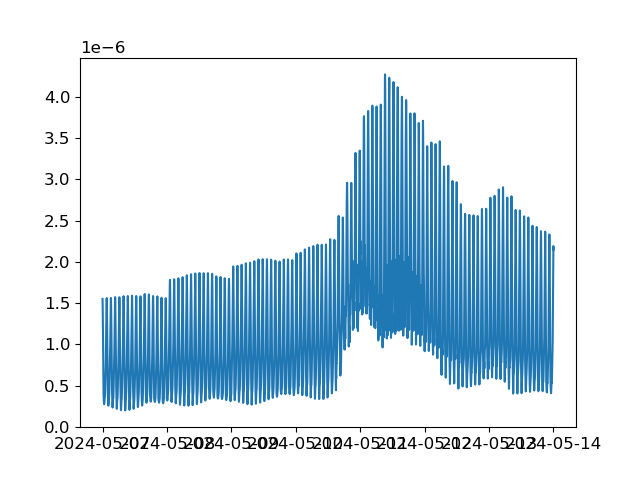

In [36]:
plt.figure()
plt.plot(df_msis.index,PO_msis)
plt.show()

In [37]:
start,stop = storm_dates[1]
df_grace = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['GRACE']
df_msis = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['MSIS']
df_gitm = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['GITM']
df_tiegcm = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['TGCM']
orbit_end = CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['orbit_end']
time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]
rho_avg_msis = [df_msis['rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
rho_avg_gitm = [df_gitm['Rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
rho_avg_tgcm = [df_tiegcm['DEN'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
O_msis = [df_msis['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
O_gitm = [df_gitm['O(!U3!NP)'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
O_tgcm = [(df_tiegcm['rho(O)']*df_tiegcm['DEN']/(m_O*m_p)).loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
temp_msis = [df_msis['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
temp_gitm = [df_gitm['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
temp_tgcm = [df_tiegcm['T_n'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

In [38]:
os.chdir('/Volumes/seagate/Temp/')
filename = 'GRACEA_Mehta_' + start.strftime("%Y-%m-%d") + '_' + stop.strftime("%Y-%m-%d") + '.csv'
df1 = pd.read_csv(filename);
df1.index = pd.DatetimeIndex(df1['Unnamed: 0'])
rho_avg = [df1['Density_New (kg_m^3)'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

In [39]:
CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"]['start']

datetime.datetime(2003, 11, 17, 0, 0)

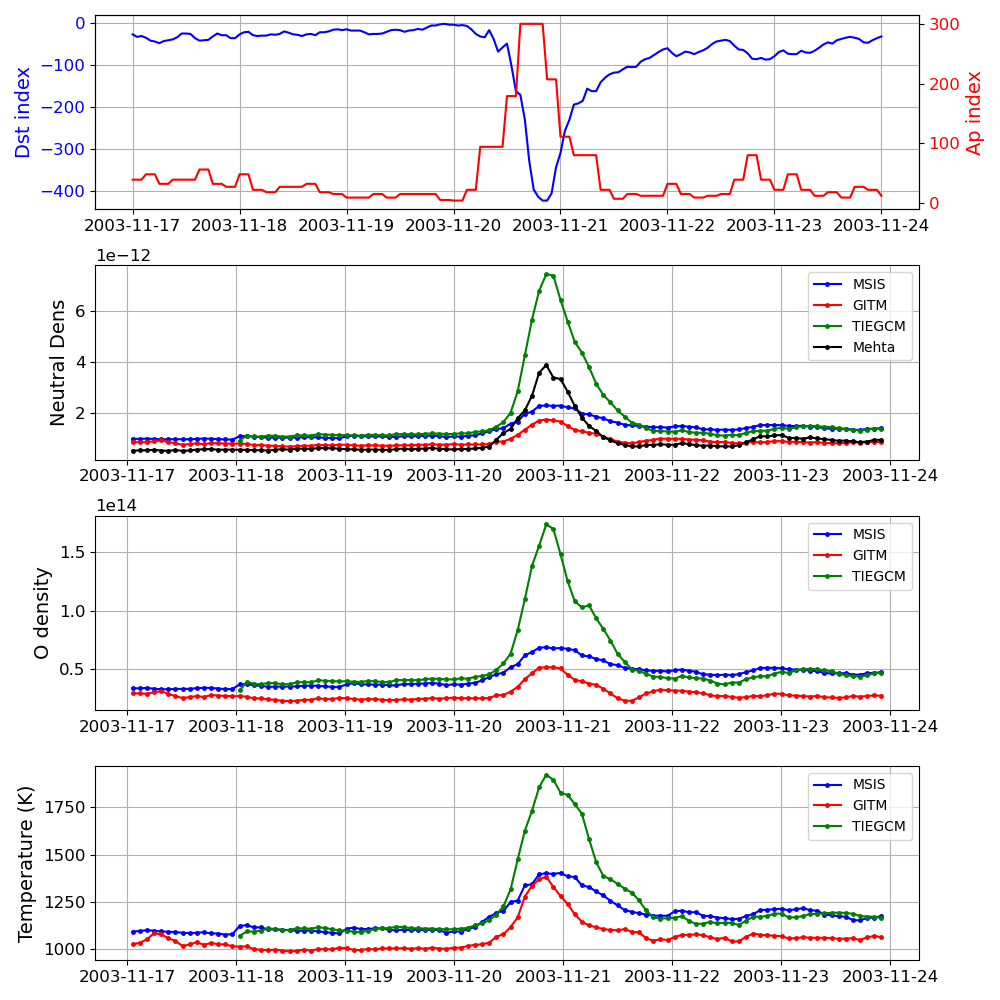

In [40]:
fig,ax = plt.subplots(4,1,figsize=(10,10))
# Plot Dst index on the left y-axis
ax[0].plot(SW_Data_hr['Dst index'].loc[start:stop], label='Dst index', color='b')
ax[0].set_ylabel('Dst index', color='b')
ax[0].tick_params(axis='y', labelcolor='b')
ax[0].grid()

# Plot Ap index on the right y-axis
ax1 = ax[0].twinx()
ax1.plot(SW_Data_hr['Ap index'].loc[start:stop], label='Ap index', color='r')
ax1.set_ylabel('Ap index', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax[1].plot(time_avg, rho_avg_msis, '-o', ms=2.5, label='MSIS', color='b')
ax[1].plot(time_avg, rho_avg_gitm, '-o', ms=2.5, label='GITM', color='r')
ax[1].plot(time_avg, rho_avg_tgcm, '-o', ms=2.5, label='TIEGCM', color='g')
ax[1].plot(time_avg, rho_avg, '-o', ms=2.5, label='Mehta', color='k')
ax[1].set_ylabel('Neutral Dens')
ax[1].grid()
ax[1].legend()

ax[2].plot(time_avg, O_msis, '-o', ms=2.5, label='MSIS', color='b')
ax[2].plot(time_avg, O_gitm, '-o', ms=2.5, label='GITM', color='r')
ax[2].plot(time_avg, O_tgcm, '-o', ms=2.5, label='TIEGCM', color='g')
ax[2].set_ylabel('O density')
ax[2].legend()
ax[2].grid()

ax[3].plot(time_avg, temp_msis, '-o', ms=2.5, label='MSIS', color='b')
ax[3].plot(time_avg, temp_gitm, '-o', ms=2.5, label='GITM', color='r')
ax[3].plot(time_avg, temp_tgcm, '-o', ms=2.5, label='TIEGCM', color='g')
ax[3].set_ylabel('Temperature (K)')
ax[3].legend()
ax[3].grid()

plt.tight_layout()
os.chdir("/Volumes/seagate/Plots/")
# 
plt.savefig(f'CD_plot_{start.strftime("%b")}_{start.strftime("%Y")}.png', dpi=1200)

In [27]:
CD_models.keys()

dict_keys(['CD_models_Oct_2003', 'CD_models_Nov_2003', 'CD_models_Nov_2004', 'CD_models_May_2024'])

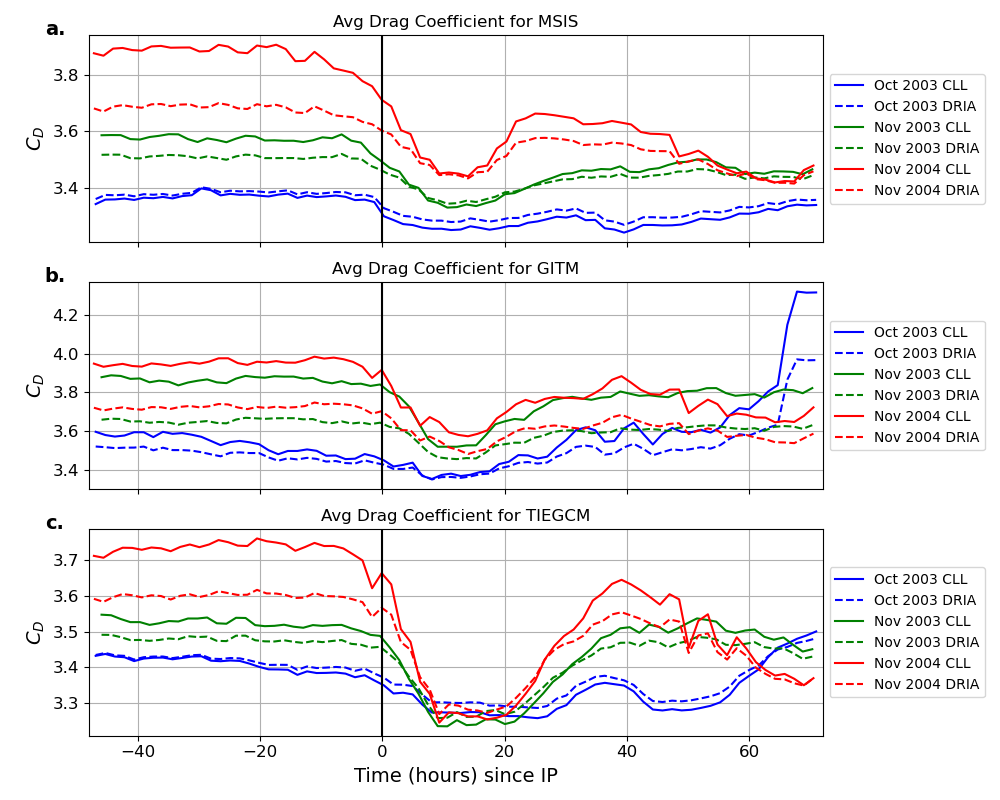

In [83]:
# plot the results
from tkinter import font


n = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors
plot_labels = ['a.', 'b.', 'c.']  # Define plot labels
for key, value in CD_models.items():
    if key in list(CD_models.keys())[:3]:
        start, stop = storm_dates[n]
        ip = ip_times[n]
        orbit_end = value['orbit_end']
        time_avg = pd.DatetimeIndex([orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)])
        
        # MSIS
        CD_CLL_avg = [value['MSIS_CLL']['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
        CD_DRIA_avg = [value['MSIS_DRIA']['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
        X = (time_avg - ip) / dt.timedelta(hours=1)
        color = colors[n % len(colors)]  # Cycle through the colors
        axs[0].plot(X, CD_CLL_avg, '-', color=color, label=f'{start.strftime("%b")} {start.strftime("%Y")} CLL')
        axs[0].plot(X, CD_DRIA_avg, '--', color=color, label=f'{start.strftime("%b")} {start.strftime("%Y")} DRIA')
        
        # GITM
        
        CD_CLL_avg = [value['GITM_CLL']['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
        CD_DRIA_avg = [value['GITM_DRIA']['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
        axs[1].plot(X, CD_CLL_avg, '-', color=color, label=f'{start.strftime("%b")} {start.strftime("%Y")} CLL')
        axs[1].plot(X, CD_DRIA_avg, '--', color=color, label=f'{start.strftime("%b")} {start.strftime("%Y")} DRIA')

        # TGCM
        CD_CLL_avg = [value['TGCM_CLL']['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
        CD_DRIA_avg = [value['TGCM_DRIA']['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
        axs[2].plot(X, CD_CLL_avg, '-', color=color, label=f'{start.strftime("%b")} {start.strftime("%Y")} CLL')
        axs[2].plot(X, CD_DRIA_avg, '--', color=color, label=f'{start.strftime("%b")} {start.strftime("%Y")} DRIA')
        
        n += 1

# Customize each subplot
for i, ax in enumerate(axs):
    ax.axvline(0, color='k', linestyle='-')
    ax.set_xlim(-48, 72)
    
    ax.set_ylabel('$C_D$',fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.text(-0.06, 1.00, plot_labels[i], transform=ax.transAxes, fontsize=14, fontweight='bold')
    ax.grid(True)
    # ax.set_ylim([3.7, 4.6])
ax.set_xlabel('Time (hours) since IP')
# Set titles for each subplot
axs[0].set_title('Avg Drag Coefficient for MSIS')
axs[1].set_title('Avg Drag Coefficient for GITM')
axs[2].set_title('Avg Drag Coefficient for TIEGCM')

plt.tight_layout()
#save the plot
os.chdir("/Volumes/seagate/Plots/")
plt.savefig('CD_comparison.png', dpi=300)
plt.show()

In [13]:
gracea = tle_ratio('GRACEA'); 
gracec = tle_ratio('GRACEC');

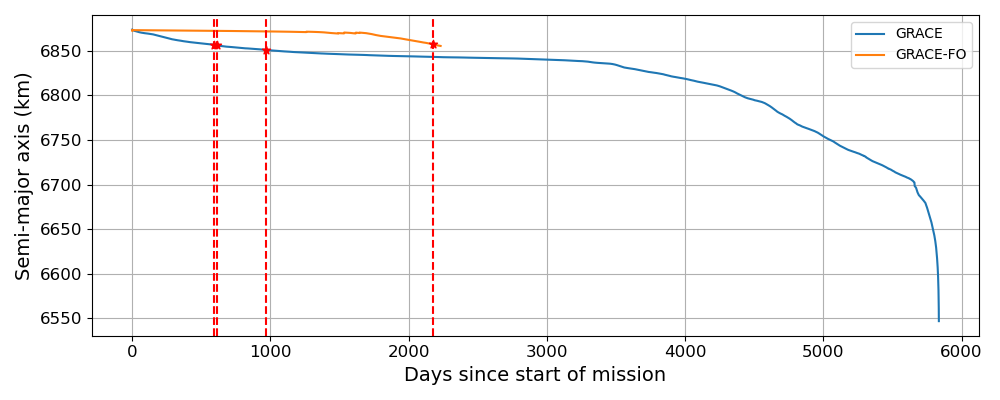

In [14]:
plt.figure(figsize=(10,4))
plt.plot((gracea.index - gracea.index[0])/dt.timedelta(days=1),gracea['a'],label='GRACE')
plt.plot((gracec.index- gracec.index[0])/dt.timedelta(days=1),gracec['a'],label='GRACE-FO')
#find nearest tle to the ip_times
for i in range(len(ip_times[:-1])):
    idx = np.argmin(np.abs(ip_times[i] - gracea.index))
    plt.scatter((gracea.index[idx] - gracea.index[0])/dt.timedelta(days=1), gracea['a'][idx], color='r', marker='*',zorder=5)
    plt.axvline((gracea.index[idx] - gracea.index[0])/dt.timedelta(days=1), color='r', linestyle='--')
# for the last event
idx = np.argmin(np.abs(ip_times[-1] - gracec.index))
plt.scatter((gracec.index[idx] - gracec.index[0])/dt.timedelta(days=1), gracec['a'][idx], color='r', marker='*',zorder=5)
plt.axvline((gracec.index[idx] - gracec.index[0])/dt.timedelta(days=1), color='r', linestyle='--')
plt.xlabel('Days since start of mission')
plt.ylabel('Semi-major axis (km)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/Volumes/seagate/Plots/GRACE_orbit.png',dpi=300)

In [24]:

CD_models = {};
for start, stop in storm_dates:
    os.chdir("/Volumes/seagate/Temp/")
    filename = f'GRACEA_{start.strftime("%b")}_{start.strftime("%Y")}_GNV.nc'
    da_grace = xr.open_dataset(filename,engine='h5netcdf')
    df_grace = da_grace.to_dataframe()
    Z = df_grace['zpos'].loc[start:stop]
    idxz = np.where(np.diff(np.sign(Z)) > 0)[0]
    orbit_end = Z.index[idxz]
    # del da;

    df_msis = pd.read_csv(f'GRACEA_{start.strftime("%b")}_{start.strftime("%Y")}_MSIS.csv')
    df_msis.index = pd.DatetimeIndex(df_msis['index'])
    df_msis = df_msis.drop(columns=['index'])
    da_msis = df_msis.to_xarray()

    df_gitm = pd.read_csv(f"grace_gitm_{start.strftime('%b')}_{start.strftime('%Y')}_aaron.csv")
    df_gitm.index = pd.DatetimeIndex(df_gitm['Unnamed: 0'])
    df_gitm = df_gitm.drop(columns=['Unnamed: 0'])
    da_gitm = df_gitm.to_xarray()

    df_grace = df_grace[~df_grace.index.duplicated(keep='first')]
    df_msis = df_msis[~df_msis.index.duplicated(keep='first')]
    df_gitm = df_gitm[~df_gitm.index.duplicated(keep='first')]

    df_grace = itrf_to_enu(df_grace, 'lat', 'lon', 'xvel', 'yvel', 'zvel')
    V = np.sqrt((df_grace['vel_east'] - df_gitm['V!Dn!N (east)'])**2 + (df_grace['vel_north'] - df_gitm['V!Dn!N (north)'])**2 + (df_grace['vel_up'] - df_gitm['V!Dn!N (up)'])**2)

    var_names = list(da_msis.variables.keys())[2:-1]
    ntot = reduce(add, (da_msis[var] for var in var_names))
    nO = df_msis['O']
    mole_frac_msis = pd.DataFrame({var: da_msis[var].values/ntot.values for var in var_names},index=pd.DatetimeIndex(da_msis['index'].values))
    # convert the output array to a pandas DataFrame with the same index as df_gitm and columns 'Vx', 'Vy', 'Vz'
    temp = df_msis['Temperature'];
    T_s = 300;

    # Ensure that the molar masses dictionary keys match the var_names
    mass_frac_msis = pd.DataFrame({
        var: mole_frac_msis[var] * molar_masses[var] for var in mole_frac_msis.columns
    }, index=mole_frac_msis.index)
    m_avg = mass_frac_msis.sum(axis=1)

    C_D = [];
    for i in range(len(df_grace)):
        CD_O = drag_sat_CLL(V[i], temp[i], 0, 0, m_O, nO[i], T_s, a, n_a, m_s) * (mass_frac_msis['O'][i] + mass_frac_msis['AnomalousOxy'][i])
        CD_N = drag_sat_CLL(V[i], temp[i], 0, 0, m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N'][i]
        CD_O2 = drag_sat_CLL(V[i], temp[i], 0, 0, m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['O2'][i]
        CD_N2 = drag_sat_CLL(V[i], temp[i], 0, 0, m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N2'][i]
        CD_He = drag_sat_CLL(V[i], temp[i], 0, 0, m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['He'][i]
        CD_H = drag_sat_CLL(V[i], temp[i], 0, 0, m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['H'][i]
        CD_Ar = drag_sat_CLL(V[i], temp[i], 0, 0, m_Ar, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['Ar'][i]
        CD_NO = drag_sat_CLL(V[i], temp[i], 0, 0, m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
        
    area = np.array([sat_area(0,0,a,n_a) for i in range(len(df_grace))]);
    CD_MSIS_CLL = pd.DataFrame({'CD':C_D,'A':area},index=df_grace.index);
    C_D = [];
    for i in range(len(df_grace)):
        CD_O = drag_sat_DRIA(V[i], temp[i], 0, 0, m_O, nO[i], T_s, a, n_a, m_s) * (mass_frac_msis['O'][i] + mass_frac_msis['AnomalousOxy'][i])
        CD_N = drag_sat_DRIA(V[i], temp[i], 0, 0, m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N'][i]
        CD_O2 = drag_sat_DRIA(V[i], temp[i], 0, 0, m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['O2'][i]
        CD_N2 = drag_sat_DRIA(V[i], temp[i], 0, 0, m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['N2'][i]
        CD_He = drag_sat_DRIA(V[i], temp[i], 0, 0, m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['He'][i]
        CD_H = drag_sat_DRIA(V[i], temp[i], 0, 0, m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['H'][i]
        CD_Ar = drag_sat_DRIA(V[i], temp[i], 0, 0, m_Ar, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['Ar'][i]
        CD_NO = drag_sat_DRIA(V[i], temp[i], 0, 0, m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_msis['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
    area = np.array([sat_area(0, 0, a, n_a) for i in range(len(df_grace.index))])
    CD_MSIS_DRIA = pd.DataFrame({'CD': C_D, 'A': area}, index=df_grace.index)

    idx = np.where((df_grace.index >= df_gitm.index[0]) & (df_grace.index <= df_gitm.index[-1]))[0];
    V = V[idx]; df_grace1 = df_grace.iloc[idx,:];
    nO = df_gitm['O(!U3!NP)'] + df_gitm['O(!U1!ND)']
    nO2 = df_gitm['O!D2!N']
    nN = df_gitm['N(!U2!ND)'] + df_gitm['N(!U2!NP)'] + df_gitm['N(!U4!NS)']
    nN2 = df_gitm['N!D2!N']
    nHe = df_gitm['He']
    nH = df_gitm['H']
    nNO = df_gitm['NO']
    ntot = nO + nO2 + nN + nN2 + nHe + nH + nNO
    mole_frac_gitm = pd.DataFrame({'O': nO / ntot, 'O2': nO2 / ntot, 'N': nN / ntot, 'N2': nN2 / ntot, 'He': nHe / ntot, 'H': nH / ntot, 'NO': nNO / ntot},
                            index=df_gitm.index)
    # Ensure that the molar masses dictionary keys match the var_names
    mass_frac_gitm = pd.DataFrame({
        var: mole_frac_gitm[var] * molar_masses[var] for var in mole_frac_gitm.columns
    }, index=mole_frac_gitm.index)
    m_avg = mass_frac_gitm.sum(axis=1)
    temp = df_gitm['Temperature']


    C_D = [];
    for i in range(len(df_grace1)):
        CD_O = drag_sat_CLL(V[i], temp[i], 0, 0, m_O, nO[i], T_s, a, n_a, m_s) * (mass_frac_gitm['O'][i])
        CD_N = drag_sat_CLL(V[i], temp[i], 0, 0, m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N'][i]
        CD_O2 = drag_sat_CLL(V[i], temp[i], 0, 0, m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['O2'][i]
        CD_N2 = drag_sat_CLL(V[i], temp[i], 0, 0, m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N2'][i]
        CD_He = drag_sat_CLL(V[i], temp[i], 0, 0, m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['He'][i]
        CD_H = drag_sat_CLL(V[i], temp[i], 0, 0, m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['H'][i]
        CD_NO = drag_sat_CLL(V[i], temp[i], 0, 0, m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
        
    area = np.array([sat_area(0,0,a,n_a) for i in range(len(df_grace1))]);
    CD_GITM_CLL = pd.DataFrame({'CD':C_D,'A':area},index=df_grace1.index);
    C_D = [];
    for i in range(len(df_grace1)):
        CD_O = drag_sat_DRIA(V[i], temp[i], 0, 0, m_O, nO[i], T_s, a, n_a, m_s) * (mass_frac_gitm['O'][i])
        CD_N = drag_sat_DRIA(V[i], temp[i], 0, 0, m_N, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N'][i]
        CD_O2 = drag_sat_DRIA(V[i], temp[i], 0, 0, m_O2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['O2'][i]
        CD_N2 = drag_sat_DRIA(V[i], temp[i], 0, 0, m_N2, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['N2'][i]
        CD_He = drag_sat_DRIA(V[i], temp[i], 0, 0, m_He, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['He'][i]
        CD_H = drag_sat_DRIA(V[i], temp[i], 0, 0, m_H, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['H'][i]
        CD_NO = drag_sat_DRIA(V[i], temp[i], 0, 0, m_NO, nO[i], T_s, a, n_a, m_s) * mass_frac_gitm['NO'][i]
        C_D.append((CD_O + CD_N + CD_O2 + CD_N2 + CD_He + CD_H + CD_Ar + CD_NO) / m_avg[i])
        
    area = np.array([sat_area(0, 0, a, n_a) for i in range(len(df_grace1.index))])
    CD_GITM_DRIA = pd.DataFrame({'CD': C_D, 'A': area}, index=df_grace1.index)
    # create a dictionary of DataFrames for each model
    CD_models[f"CD_models_{start.strftime('%b')}_{start.strftime('%Y')}"] = {
        'MSIS_CLL': CD_MSIS_CLL,
        'MSIS_DRIA': CD_MSIS_DRIA,
        'GITM_CLL': CD_GITM_CLL,
        'GITM_DRIA': CD_GITM_DRIA,
        'GRACE': df_grace,
        'MSIS': df_msis,
        'GITM': df_gitm,
        'orbit_end': orbit_end,
    }
    # # save the dictionary of DataFrames to a pickle file
    # os.chdir("/Volumes/seagate/Temp/")
    # filename = f'CD_{start.strftime("%b")}_{start.strftime("%Y")}.pkl'
    # with open(filename, 'wb') as file:
    #     pickle.dump(CD_models, file)

In [26]:
#save the dictionary of DataFrames to a pickle file
os.chdir("/Volumes/seagate/Temp/")
filename = f'CD_models.pkl'
with open(filename, 'wb') as file:
    pickle.dump(CD_models, file)


## plots

In [49]:
# open the pickle file containing the dictionary of DataFrames
os.chdir("/Volumes/seagate/Temp/")
filename = f'CD_models.pkl'
with open(filename, 'rb') as file:
    CD_models = pickle.load(file)
    print(CD_models.keys())

dict_keys(['CD_models_Oct_2003', 'CD_models_Nov_2003', 'CD_models_Nov_2004', 'CD_models_May_2024'])


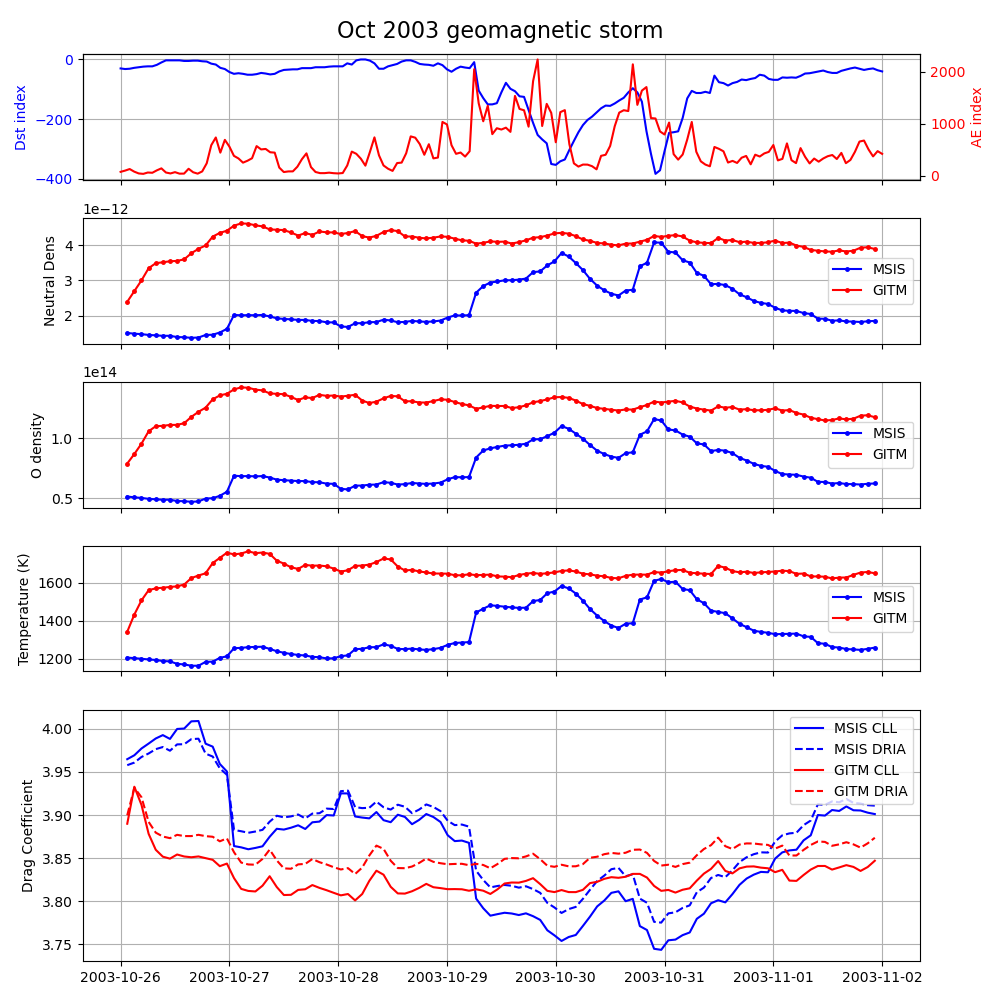

In [89]:
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1, 1, 2]})

# Plot Dst index on the left y-axis
ax[0].plot(SW_Data_hr['Dst index'].loc[start:stop], label='Dst index', color='b')
ax[0].set_ylabel('Dst index', color='b')
ax[0].tick_params(axis='y', labelcolor='b')
ax[0].grid()

# Create a twin y-axis to plot AE index
ax1 = ax[0].twinx()
ax1.plot(SW_Data_hr['AE'].loc[start:stop], label='AE index', color='r')
ax1.set_ylabel('AE index', color='r')
ax1.tick_params(axis='y', labelcolor='r')

time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]
rho_avg_msis = [df_msis['rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
rho_avg_gitm = [df_gitm['Rho'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

ax[1].plot(time_avg, rho_avg_msis, '-o', ms=2.5, label='MSIS', color='b')
ax[1].plot(time_avg, rho_avg_gitm, '-o', ms=2.5, label='GITM', color='r')
ax[1].set_ylabel('Neutral Dens')
ax[1].grid()
ax[1].legend()

O_msis = [df_msis['O'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
O_gitm = [df_gitm['O(!U3!NP)'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
time_avg = [orbit_end[i] + (orbit_end[i+1] - orbit_end[i])/2 for i in range(len(orbit_end)-1)]

ax[2].plot(time_avg, O_msis, '-o', ms=2.5, label='MSIS', color='b')
ax[2].plot(time_avg, O_gitm, '-o', ms=2.5, label='GITM', color='r')
ax[2].set_ylabel('O density')
ax[2].legend()
ax[2].grid()

# Plot the temperature from MSIS and GITM
# Calculate avg temperature using orbit_end
temp_msis = [df_msis['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
temp_gitm = [df_gitm['Temperature'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
ax[3].plot(time_avg, temp_msis, '-o', ms=2.5, label='MSIS', color='b')
ax[3].plot(time_avg, temp_gitm, '-o', ms=2.5, label='GITM', color='r')
ax[3].set_ylabel('Temperature (K)')
ax[3].legend()
ax[3].grid()

CD_MSIS_CLL_avg = [CD_MSIS_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_MSIS_DRIA_avg = [CD_MSIS_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_GITM_CLL_avg = [CD_GITM_CLL['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]
CD_GITM_DRIA_avg = [CD_GITM_DRIA['CD'].loc[orbit_end[i]:orbit_end[i+1]].mean() for i in range(len(orbit_end)-1)]

ax[4].plot(time_avg, CD_MSIS_CLL_avg, '-', ms=2.5, label='MSIS CLL', color='b')
ax[4].plot(time_avg, CD_MSIS_DRIA_avg, '--', ms=2.5, label='MSIS DRIA', color='b')
ax[4].plot(time_avg, CD_GITM_CLL_avg, '-', ms=2.5, label='GITM CLL', color='r')
ax[4].plot(time_avg, CD_GITM_DRIA_avg, '--', ms=2.5, label='GITM DRIA', color='r')
ax[4].set_ylabel('Drag Coefficient')
ax[4].legend(loc='upper right')
ax[4].grid()
# add a title to the figure
fig.suptitle(f'{start.strftime("%b")} {start.strftime("%Y")} geomagnetic storm',fontsize=16)
plt.tight_layout()
#save the figure
os.chdir("/Volumes/seagate/Temp/")
plt.savefig(f'CD_{start.strftime("%b")}_{start.strftime("%Y")}.png',dpi=300)
plt.show()

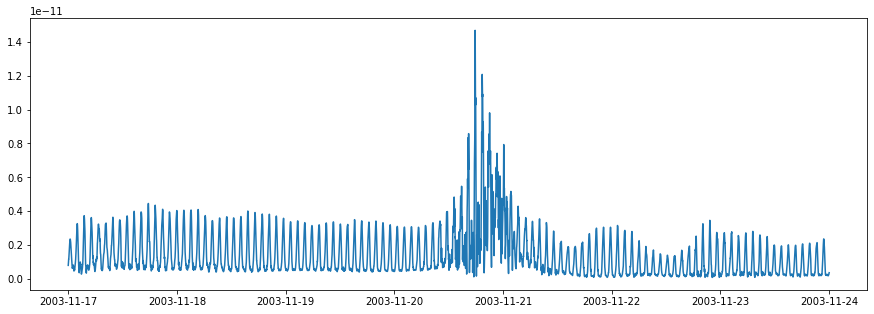

In [47]:
plt.figure(figsize=(15,5))
# plt.plot(df_msis['rho'])
plt.plot(df_gitm['Rho'])